In [1]:
import pickle

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score

from scipy.sparse import csr_matrix, hstack, vstack

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
sns.set()

In [2]:
path = '../../data/'
train_df = pd.read_csv(path+'train_sessions.csv', index_col='session_id')
test_df = pd.read_csv(path+'test_sessions.csv', index_col='session_id')
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 253561 entries, 1 to 253561
Data columns (total 21 columns):
site1     253561 non-null int64
time1     253561 non-null object
site2     250098 non-null float64
time2     250098 non-null object
site3     246919 non-null float64
time3     246919 non-null object
site4     244321 non-null float64
time4     244321 non-null object
site5     241829 non-null float64
time5     241829 non-null object
site6     239495 non-null float64
time6     239495 non-null object
site7     237297 non-null float64
time7     237297 non-null object
site8     235224 non-null float64
time8     235224 non-null object
site9     233084 non-null float64
time9     233084 non-null object
site10    231052 non-null float64
time10    231052 non-null object
target    253561 non-null int64
dtypes: float64(9), int64(2), object(10)
memory usage: 42.6+ MB


## Correct time-aware cross-validation
In order to do correct cross-validation on time-series, we need to first sort the training data by date in ascending manner

__NOTE__: prior doing this I had really good results on cross-validation but on test data the results weren't as much fine.

In [3]:
times = ['time%s'%i for i in range(1,11)]
sites = ['site%s'%i for i in range(1,11)]

train_df[times] = train_df[times].apply(pd.to_datetime)
train_df[sites] = train_df[sites].fillna(0).astype(np.uint16)
test_df[times] = test_df[times].apply(pd.to_datetime)
test_df[sites] = test_df[sites].fillna(0).astype(np.uint16)

tsf = TimeSeriesSplit(n_splits=10)
skf = StratifiedKFold(n_splits=10, random_state=17)

train_df = train_df.sort_values(by='time1')
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55,2013-01-12 08:05:57,0,NaT,0,NaT,0,NaT,...,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0
54843,56,2013-01-12 08:37:23,55,2013-01-12 08:37:23,56,2013-01-12 09:07:07,55,2013-01-12 09:07:09,0,NaT,...,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0
77292,946,2013-01-12 08:50:13,946,2013-01-12 08:50:14,951,2013-01-12 08:50:15,946,2013-01-12 08:50:15,946,2013-01-12 08:50:16,...,2013-01-12 08:50:16,948,2013-01-12 08:50:16,784,2013-01-12 08:50:16,949,2013-01-12 08:50:17,946,2013-01-12 08:50:17,0
114021,945,2013-01-12 08:50:17,948,2013-01-12 08:50:17,949,2013-01-12 08:50:18,948,2013-01-12 08:50:18,945,2013-01-12 08:50:18,...,2013-01-12 08:50:18,947,2013-01-12 08:50:19,945,2013-01-12 08:50:19,946,2013-01-12 08:50:19,946,2013-01-12 08:50:20,0
146670,947,2013-01-12 08:50:20,950,2013-01-12 08:50:20,948,2013-01-12 08:50:20,947,2013-01-12 08:50:21,950,2013-01-12 08:50:21,...,2013-01-12 08:50:21,946,2013-01-12 08:50:21,951,2013-01-12 08:50:22,946,2013-01-12 08:50:22,947,2013-01-12 08:50:22,0


In [4]:
full_df = pd.concat([train_df.drop(columns='target'), test_df], axis=0)
y_train = train_df['target']

train_idx = train_df.shape[0]
full_df.head(5)

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,site6,time6,site7,time7,site8,time8,site9,time9,site10,time10
session_id,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55,2013-01-12 08:05:57,0,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0,NaT
54843,56,2013-01-12 08:37:23,55,2013-01-12 08:37:23,56,2013-01-12 09:07:07,55,2013-01-12 09:07:09,0,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0,NaT
77292,946,2013-01-12 08:50:13,946,2013-01-12 08:50:14,951,2013-01-12 08:50:15,946,2013-01-12 08:50:15,946,2013-01-12 08:50:16,945,2013-01-12 08:50:16,948,2013-01-12 08:50:16,784,2013-01-12 08:50:16,949,2013-01-12 08:50:17,946,2013-01-12 08:50:17
114021,945,2013-01-12 08:50:17,948,2013-01-12 08:50:17,949,2013-01-12 08:50:18,948,2013-01-12 08:50:18,945,2013-01-12 08:50:18,946,2013-01-12 08:50:18,947,2013-01-12 08:50:19,945,2013-01-12 08:50:19,946,2013-01-12 08:50:19,946,2013-01-12 08:50:20
146670,947,2013-01-12 08:50:20,950,2013-01-12 08:50:20,948,2013-01-12 08:50:20,947,2013-01-12 08:50:21,950,2013-01-12 08:50:21,952,2013-01-12 08:50:21,946,2013-01-12 08:50:21,951,2013-01-12 08:50:22,946,2013-01-12 08:50:22,947,2013-01-12 08:50:22


In [5]:
train_df.shape, test_df.shape, full_df.shape

((253561, 21), (82797, 20), (336358, 20))

***
## `CountVectorizer` and `csr_matrix` comparison

In [6]:
train_df[sites].to_csv('./statics/train_sessions_text.txt', 
                                               sep=' ', 
                                               index=None, 
                                               header=None)
test_df[sites].to_csv('./statics/test_sessions_text.txt', 
                                              sep=' ', 
                                              index=None,
                                              header=None)

!head -5 ./statics/train_sessions_text.txt

56 55 0 0 0 0 0 0 0 0
56 55 56 55 0 0 0 0 0 0
946 946 951 946 946 945 948 784 949 946
945 948 949 948 945 946 947 945 946 946
947 950 948 947 950 952 946 951 946 947


In [7]:
values = full_df[sites].values.flatten()
csr_full_sparse = csr_matrix(([1] * values.shape[0],
                          values,
                          range(0, values.shape[0]+10, 10)))[:, 1:]

CV = CountVectorizer(ngram_range=(1,10), token_pattern=r'(?u)\b\w+\b', stop_words={'0'}, max_features=100000)
with open('./statics/train_sessions_text.txt') as inp_train_file:
    X_train = CV.fit_transform(inp_train_file)
with open('./statics/test_sessions_text.txt') as inp_test_file:
    X_test = CV.transform(inp_test_file)
cv_full_sparse = vstack([X_train, X_test])

lr = LogisticRegression(random_state=17)

print(csr_full_sparse.shape)
print(cv_full_sparse.shape)
# prints the same, if CountVectorizer arguments set to {ngram_range={1,1}, max_features=None}

(336358, 48371)
(336358, 100000)


In [8]:
X_train_cv = cv_full_sparse[:train_idx]
X_train_csr = csr_full_sparse[:train_idx]
print('ROC-AUC for CountVector:', cross_val_score(lr, X_train_cv , y_train, scoring='roc_auc', 
                                                  cv=tsf, n_jobs=-1).mean())
print('ROC-AUC for csr_matrix: ', cross_val_score(lr, X_train_csr, y_train, scoring='roc_auc', 
                                                  cv=tsf, n_jobs=-1).mean())

ROC-AUC for CountVector: 0.8658715181943307
ROC-AUC for csr_matrix:  0.865795605613054


## Verdict regarding `CountVectorizer` and `csr_matrix`
The `CountVector` showed slightly better results than `csr_matrix`, so we will stick with `CountVector` to reduce the computation and testing time. We could <font color='blue'>afterwards</font> experiment with `csr_matrix`

In [9]:
def_score = cross_val_score(lr, X_train_cv , y_train, scoring='roc_auc', cv=tsf, n_jobs=-1).mean()

In [10]:
del train_df, test_df, path

In [11]:
del CV, inp_test_file, inp_train_file, csr_full_sparse, X_train_csr, X_train_cv, X_train, X_test, values

***
## Data analysis, hypothesis testing, and feature generation

### Testing cyclic feature - sinus and cosinus - of time.

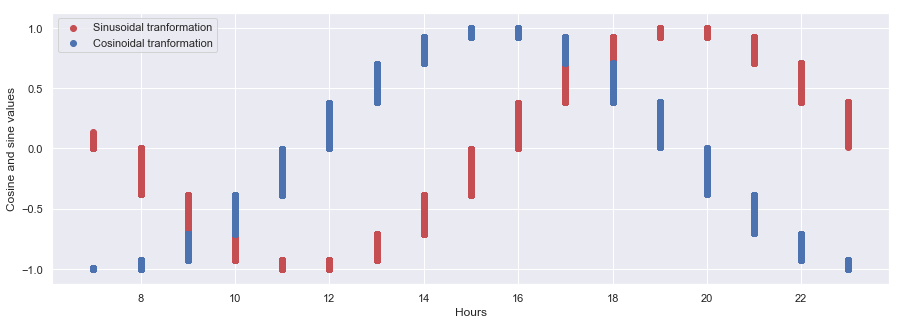

In [12]:
tmp = full_df['time1'].dt.hour*60 + full_df['time1'].dt.minute
tmp = pd.concat([tmp.rename('minutes'), full_df['time1'].dt.hour.rename('hours')], axis=1)

plt.figure(figsize=(15,5))
plt.scatter(tmp.hours.sample(frac=0.2, random_state=17), 
            np.sin(2*np.pi*tmp.minutes.sample(frac=0.2, random_state=17)/(16*60)), 
            c='r', label='Sinusoidal tranformation')
plt.scatter(tmp.hours.sample(frac=0.2, random_state=17), 
            np.cos(2*np.pi*tmp.minutes.sample(frac=0.2, random_state=17)/(16*60)), 
            c='b', label='Cosinoidal tranformation')
plt.xlabel('Hours')
plt.ylabel('Cosine and sine values')
plt.legend()
plt.show()

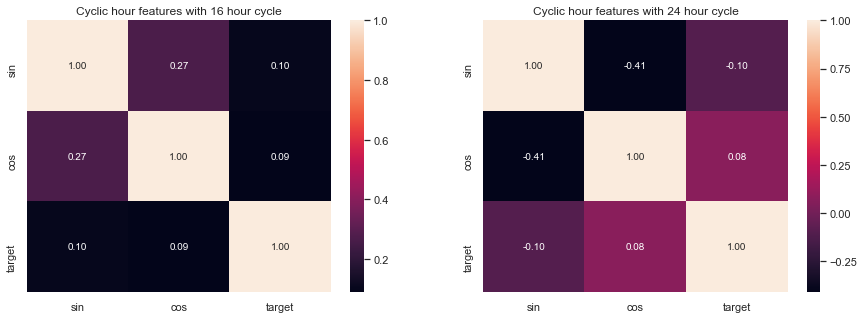

In [13]:
tmp = full_df[:train_idx]['time1']
tmp = tmp.dt.hour*60 + tmp.dt.minute

sin = np.sin(2*np.pi*tmp/(16*60)).rename('sin')
cos = np.cos(2*np.pi*tmp/(16*60)).rename('cos')

X_train = pd.concat([sin, cos, y_train], axis=1)

plt.figure(figsize=(15,5))
plt.subplot('121')
sns.heatmap(X_train.corr(), annot=True, fmt='.2f')
plt.title('Cyclic hour features with 16 hour cycle')

sin = np.sin(2*np.pi*tmp/(24*60)).rename('sin')
cos = np.cos(2*np.pi*tmp/(24*60)).rename('cos')

X_train = pd.concat([sin, cos, y_train], axis=1)

plt.subplot('122')
sns.heatmap(X_train.corr(), annot=True, fmt='.2f')
plt.title('Cyclic hour features with 24 hour cycle')
plt.show()

In [14]:
def add_cyclic(ts, X_sparse):
    tmp = ts.dt.hour*60 + ts.dt.minute
    cos = np.cos(2*np.pi*tmp/(16*60)).values.reshape((-1,1))
    sin = np.sin(2*np.pi*tmp/(16*60)).values.reshape((-1,1))
    return hstack([cos, sin, X_sparse])

In [15]:
X_train = cv_full_sparse[:train_idx]
X_train = add_cyclic(full_df[:train_idx]['time1'], X_train)
def_score1 = cross_val_score(lr, X_train, y_train, scoring='roc_auc', cv=tsf, n_jobs=-1).mean()
print('ROC-AUC without cyclic features:', def_score)
print('ROC-AUC with cyclic features:   ', def_score1)

ROC-AUC without cyclic features: 0.8658715181943307
ROC-AUC with cyclic features:    0.8948600689245586


In [16]:
del sin, cos, tmp, X_train

### Add hour feature

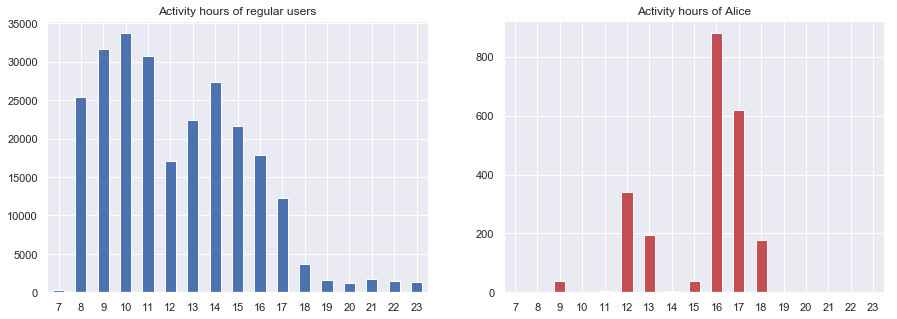

In [17]:
tmp = full_df[:train_idx]['time1'].dt.hour
tmp = pd.get_dummies(tmp)

plt.subplots(1,2,figsize=(15,5))
axes = plt.gcf().get_axes()
tmp[y_train==0].sum(axis=0).plot(kind='bar', color='b', rot=0, ax=axes[0])
tmp[y_train==1].sum(axis=0).plot(kind='bar', color='r', rot=0, ax=axes[1])
axes[0].set_title('Activity hours of regular users')
axes[1].set_title('Activity hours of Alice')
plt.show()

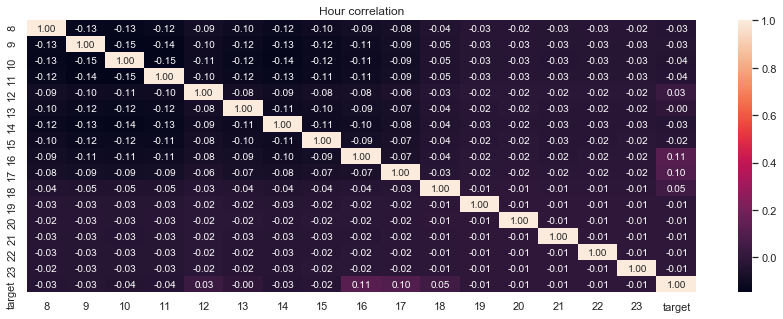

In [18]:
tmp = full_df[:train_idx]['time1']
tmp = pd.get_dummies(tmp.dt.hour, drop_first=True)

X_train = pd.concat([tmp, y_train], axis=1)

plt.figure(figsize=(15,5))
sns.heatmap(X_train.corr(), annot=True, fmt='.2f')
plt.title('Hour correlation')
plt.show()

In [19]:
def add_hours(ts, X_sparse):
    hours = pd.get_dummies(ts.dt.hour, drop_first=True)
    cols = np.arange(2,24)
    hours = hours.T.reindex(cols).T.fillna(0).astype(int).values
    return hstack([hours, X_sparse])

In [20]:
X_train = cv_full_sparse[:train_idx]
X_train = add_hours(full_df[:train_idx]['time1'], X_train)
X_train = add_cyclic(full_df[:train_idx]['time1'], X_train)
def_score2 = cross_val_score(lr, X_train, y_train, scoring='roc_auc', cv=tsf, n_jobs=-1).mean()
print('ROC-AUC without dummy hours features:', def_score1)
print('ROC-AUC with dummy hours features:   ', def_score2)

ROC-AUC without dummy hours features: 0.8948600689245586
ROC-AUC with dummy hours features:    0.9091696492282264


In [21]:
del tmp, axes, X_train

### Alice active hour features
Let's check the active hours of Alice by importance, and depending on that derive features.

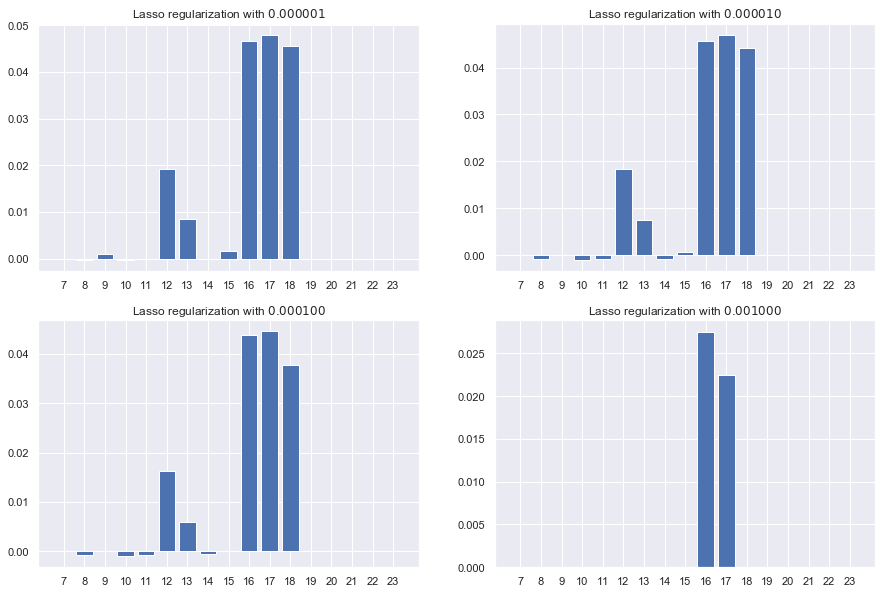

In [22]:
from sklearn.linear_model import Lasso

_, axes = plt.subplots(2, 2, figsize=(15,10))

tmp = pd.get_dummies(full_df[:train_idx]['time1'].dt.hour)
a_values = np.logspace(-6,-3,4)

for i, ax in enumerate(axes.flatten()):
    l = Lasso(alpha=a_values[i])
    l.fit(tmp.values, y_train)
    ax.bar(tmp.columns, l.coef_)
    ax.set_xticks(tmp.columns)
    ax.set_title("Lasso regularization with $%.6f$" % a_values[i])

plt.show()

Seems like there several hours when Alice is super active and few when not so much. Let's create features corresponding to active hours of Alice.

In [23]:
def add_active_hours(ts, X_sparse):
    hour = ts.dt.hour
    active1 = ((hour>=12) & (hour<=13)).astype(int).values.reshape((-1,1))
    active2 = ((hour>=16) & (hour<=18)).astype(int).values.reshape((-1,1))
    active3 = (((hour>=7) & (hour<=11))|((hour>=14) & (hour<=15))).astype(int).values.reshape((-1,1))
    return hstack([active1, active2, active3, X_sparse])

In [24]:
X_train = cv_full_sparse[:train_idx]
X_train = add_hours(full_df[:train_idx]['time1'], X_train)
X_train = add_cyclic(full_df[:train_idx]['time1'], X_train)
X_train = add_active_hours(full_df[:train_idx]['time1'], X_train)
def_score3t = cross_val_score(lr, X_train, y_train, scoring='roc_auc', cv=tsf, n_jobs=-1).mean()
def_score3s = cross_val_score(lr, X_train, y_train, scoring='roc_auc', cv=skf, n_jobs=-1).mean()
print('ROC-AUC without active hours features:', def_score2)
print('ROC-AUC with time-series split:       ', def_score3t)
print('ROC-AUC with stratified k-fold split: ', def_score3s)
print('ROC-AUC mean:                         ', np.mean([def_score3t, def_score3s]))

ROC-AUC without active hours features: 0.9091696492282264
ROC-AUC with time-series split:        0.9119158491757237
ROC-AUC with stratified k-fold split:  0.9490558652170182
ROC-AUC mean:                          0.930485857196371


In [25]:
del tmp, a_values, axes, X_train

### Session length
The mean time in minutes of session

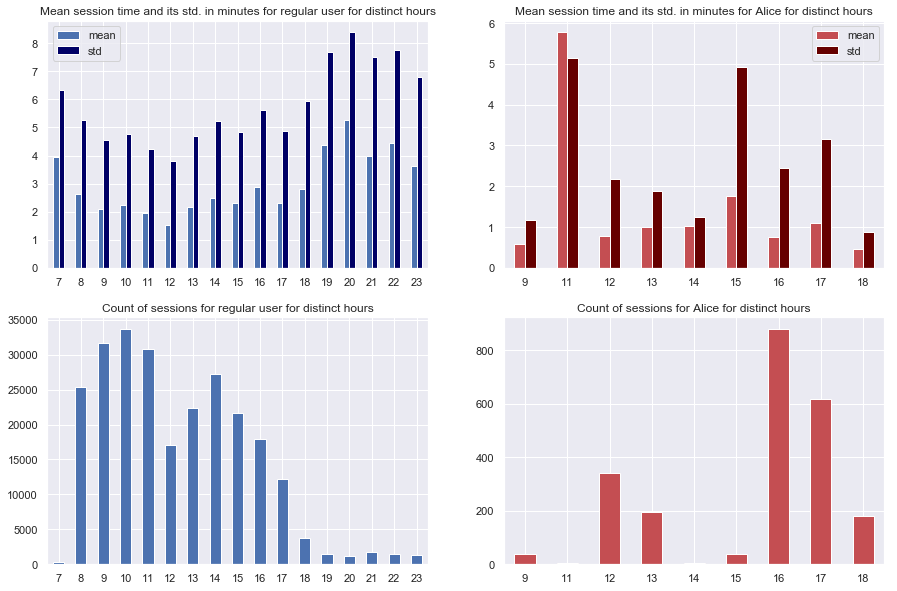

In [26]:
tmp = pd.concat([((full_df[:train_idx][times].max(axis=1) - \
                  full_df[:train_idx][times].min(axis=1)) / pd.Timedelta(minutes=1)).rename('long'),
                  pd.get_dummies(full_df[:train_idx]['time1'].dt.hour)], axis=1)

tmp1 = tmp[y_train==0].groupby(list(range(7,24)))['long'].agg(['mean','std', 'count']).reset_index(drop=True)
tmp1.index = range(23, 6, -1)
tmp1 = tmp1.sort_index()

tmp2 = tmp[y_train==1].groupby(list(range(7,24)))['long'].agg(['mean', 'std', 'count']).reset_index(drop=True)
tmp2.index = list(range(18, 10,-1)) + [9]
tmp2 = tmp2.sort_index()

plt.subplots(2,2, figsize=(15,10))
axes=plt.gcf().get_axes()
tmp1[['mean', 'std']].plot(kind='bar', color = ['b', '#000066'], rot=0, ax=axes[0])
tmp2[['mean', 'std']].plot(kind='bar', color = ['r', '#660000'], rot=0, ax=axes[1])
tmp1['count'].plot(kind='bar', color = 'b', rot=0, ax=axes[2])
tmp2['count'].plot(kind='bar', color = 'r', rot=0, ax=axes[3])
axes[0].set_title('Mean session time and its std. in minutes for regular user for distinct hours')
axes[1].set_title('Mean session time and its std. in minutes for Alice for distinct hours')
axes[2].set_title('Count of sessions for regular user for distinct hours')
axes[3].set_title('Count of sessions for Alice for distinct hours')
plt.show()

Let's test it.

In [27]:
def add_session_length(ts, X_sparse):
    tmp = ((ts.max(axis=1)-ts.min(axis=1))/pd.Timedelta(minutes=1)).values.reshape(-1,1)
    tmp = StandardScaler().fit_transform(tmp.reshape(-1,1))
    return hstack([tmp, X_sparse])

In [28]:
X_train = cv_full_sparse[:train_idx]
X_train = add_hours(full_df[:train_idx]['time1'], X_train)
X_train = add_cyclic(full_df[:train_idx]['time1'], X_train)
X_train = add_active_hours(full_df[:train_idx]['time1'], X_train)
X_train = add_session_length(full_df[:train_idx][times], X_train)
def_score4t = cross_val_score(lr, X_train, y_train, scoring='roc_auc', cv=tsf, n_jobs=-1).mean()
def_score4s = cross_val_score(lr, X_train, y_train, scoring='roc_auc', cv=skf, n_jobs=-1).mean()
print('ROC-AUC without session length feature:', np.mean([def_score3t, def_score3s]))
print('ROC-AUC with time-series split:        ', def_score4t)
print('ROC-AUC with stratified k-fold split:  ', def_score4s)
print('ROC-AUC mean:                          ', np.mean([def_score4t, def_score4s]))

ROC-AUC without session length feature: 0.930485857196371
ROC-AUC with time-series split:         0.9125483338056422
ROC-AUC with stratified k-fold split:   0.9492053607744413
ROC-AUC mean:                           0.9308768472900417


In [29]:
del tmp, tmp1, tmp2, axes, X_train

### Standard deviation of intervals between sites within session 
Some data visualization in order to see if new feature actually can make a difference

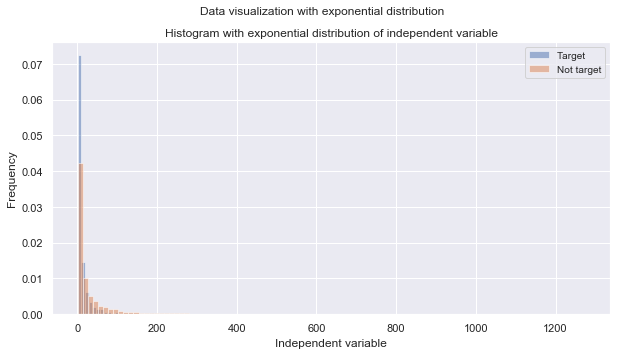

,std,target
1,1.000000,0
2,11.354280,0
3,3.043961,0
4,91.829511,0
5,69.315363,0


In [30]:
tmp = full_df[:train_idx][times]
tmp = tmp.applymap(lambda x: x if pd.isna(x) else x.value/1000000000).std(axis=1).fillna(0)+1

tmp = pd.concat([tmp.rename('std'), y_train], axis=1)
tmp.loc[tmp.target==1, 'std'].hist(label='Target',
                                   normed=True, 
                                   alpha=0.5, 
                                   bins=100, 
                                   figsize=(10,5))
tmp.loc[tmp.target==0, 'std'].hist(label='Not target', 
                                   normed=True, 
                                   alpha=0.5,
                                   bins=100)
plt.suptitle('Data visualization with exponential distribution')
plt.title('Histogram with exponential distribution of independent variable')
plt.xlabel('Independent variable')
plt.ylabel('Frequency')
plt.legend(fontsize=10)
plt.show()

tmp.head()

,std,target
1,0.000000,0
2,2.429595,0
3,1.113160,0
4,4.519934,0
5,4.238667,0


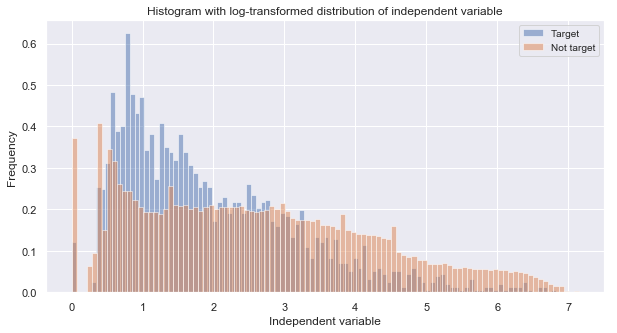

In [31]:
tmp['std'] = np.log(tmp['std'])

tmp.loc[tmp.target==1, 'std'].hist(label='Target',
                                   normed=True, 
                                   alpha=0.5, 
                                   bins=100, 
                                   figsize=(10,5))
tmp.loc[tmp.target==0, 'std'].hist(label='Not target', 
                                   normed=True, 
                                   alpha=0.5,
                                   bins=100)
plt.title('Histogram with log-transformed distribution of independent variable')
plt.xlabel('Independent variable')
plt.ylabel('Frequency')
plt.legend(fontsize=10)
plt.savefig('./statics/fig2')

tmp.head()

Seems like there is some dependence of targent variable based on this new feature, so we shall test this hypothesis.

In [32]:
def add_session_std(ts, X_sparse):
    tmp = ts.applymap(lambda x: x if pd.isna(x) else x.value/1000000000).std(axis=1).fillna(0)
    tmp = tmp.apply(np.log1p)
    ss = StandardScaler()
    timeStd = ss.fit_transform(tmp.values.reshape((-1,1)))
    return hstack([timeStd, X_sparse])

In [33]:
X_train = cv_full_sparse[:train_idx, :]
X_train = add_hours(full_df[:train_idx]['time1'], X_train)
X_train = add_cyclic(full_df[:train_idx]['time1'], X_train)
X_train = add_active_hours(full_df[:train_idx]['time1'], X_train)
X_train = add_session_length(full_df[:train_idx][times], X_train)
X_train = add_session_std(full_df[:train_idx][times], X_train)
def_score5t = cross_val_score(lr, X_train, y_train, cv=tsf, scoring='roc_auc', n_jobs=-1).mean()
def_score5s = cross_val_score(lr, X_train, y_train, cv=skf, scoring='roc_auc', n_jobs=-1).mean()
print('ROC-AUC for baseline model:          ', np.mean([def_score4s, def_score4t]))
print('ROC-AUC with time-series split:      ', def_score5t)
print('ROC-AUC with stratified k-fold split:', def_score5s)
print('ROC-AUC mean:                        ', np.mean([def_score5t, def_score5s]))

ROC-AUC for baseline model:           0.9308768472900417
ROC-AUC with time-series split:       0.9128375144994688
ROC-AUC with stratified k-fold split: 0.9492501527765155
ROC-AUC mean:                         0.9310438336379921


In [34]:
del tmp, X_train

### Alice active week day features

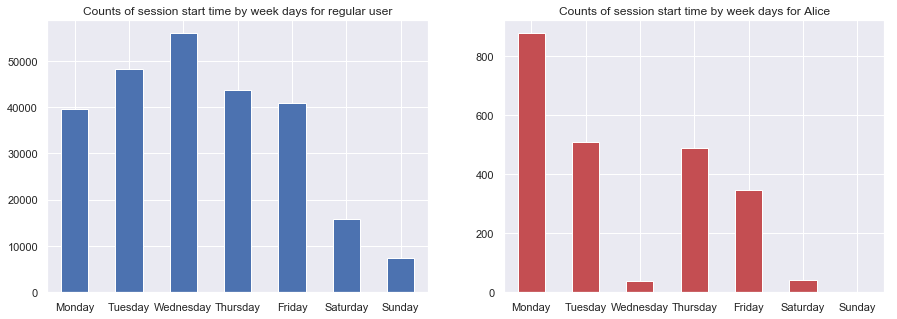

In [35]:
import calendar

tmp = full_df[:train_idx]['time1'].dt.weekday
tmp1 = tmp[y_train==0].value_counts().sort_index() \
                    .rename(index=dict(zip(range(0,7), list(calendar.day_name))))
tmp2 = tmp[y_train==1].value_counts().sort_index() \
                    .rename(index=dict(zip(range(0,7), list(calendar.day_name))))

plt.subplots(1,2, figsize=(15,5))
axes=plt.gcf().get_axes()
tmp1.plot(kind='bar', color='b', rot=0, ax=axes[0])
tmp2.plot(kind='bar', color='r', rot=0, ax=axes[1])
axes[0].set_title('Counts of session start time by week days for regular user')
axes[1].set_title('Counts of session start time by week days for Alice')
plt.show()

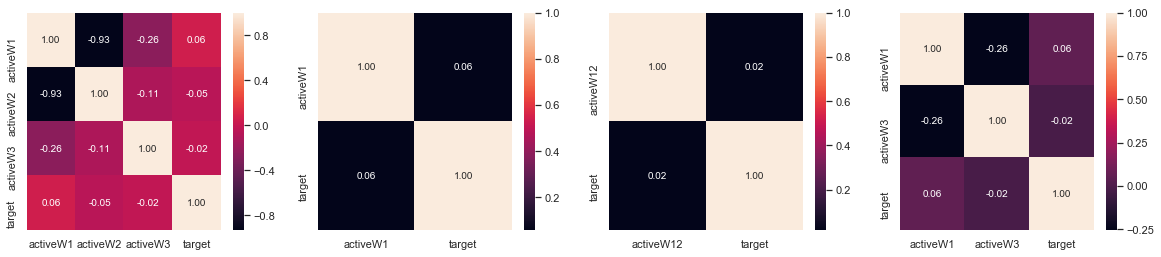

In [36]:
_, axes = plt.subplots(1, 4, figsize=(20,4))

active1 = (((tmp>=0) & (tmp<=1))|((tmp>=3) & (tmp<=4))).astype(int).rename('activeW1')
active2 = ((tmp==2) | (tmp==5)).astype(int).rename('activeW2')
active3 = (tmp==6).astype(int).rename('activeW3')
X_train = pd.concat([active1, active2, active3, y_train], axis=1)

sns.heatmap(X_train.corr(), annot=True, fmt='.2f', ax=axes[0])

active1 = (((tmp>=0) & (tmp<=1))|((tmp>=3) & (tmp<=4))).astype(int).rename('activeW1')
X_train = pd.concat([active1, y_train], axis=1)

sns.heatmap(X_train.corr(), annot=True, fmt='.2f', ax=axes[1])

active1 = ((tmp>=0) & (tmp<=5)).astype(int).rename('activeW12')
X_train = pd.concat([active1, y_train], axis=1)

sns.heatmap(X_train.corr(), annot=True, fmt='.2f', ax=axes[2])

active1 = (((tmp>=0) & (tmp<=1))|((tmp>=3) & (tmp<=4))).astype(int).rename('activeW1')
active3 = (tmp==6).astype(int).rename('activeW3')
X_train = pd.concat([active1, active3, y_train], axis=1)

sns.heatmap(X_train.corr(), annot=True, fmt='.2f', ax=axes[3])
plt.show()

In [37]:
def add_active_week_day(ts, X_sparse):
    tmp = ts.dt.weekday
    active1 = (((tmp>=0) & (tmp<=1))|((tmp>=3) & (tmp<=4))).astype(int).values.reshape((-1,1))
    return hstack([active1, X_sparse])

In [38]:
X_train = cv_full_sparse[:train_idx]
X_train = add_hours(full_df[:train_idx]['time1'], X_train)
X_train = add_cyclic(full_df[:train_idx]['time1'], X_train)
X_train = add_active_hours(full_df[:train_idx]['time1'], X_train)
X_train = add_session_length(full_df[:train_idx][times], X_train)
X_train = add_session_std(full_df[:train_idx][times], X_train)
X_train = add_active_week_day(full_df[:train_idx]['time1'], X_train)
def_score6t = cross_val_score(lr, X_train, y_train, cv=tsf, scoring='roc_auc', n_jobs=-1).mean()
def_score6s = cross_val_score(lr, X_train, y_train, cv=skf, scoring='roc_auc', n_jobs=-1).mean()
print('ROC-AUC for baseline model:          ', np.mean([def_score5s, def_score5t]))
print('ROC-AUC with time-series split:      ', def_score6t)
print('ROC-AUC with stratified k-fold split:', def_score6s)
print('ROC-AUC mean:                        ', np.mean([def_score6t, def_score6s]))

ROC-AUC for baseline model:           0.9310438336379921
ROC-AUC with time-series split:       0.9182286084086486
ROC-AUC with stratified k-fold split: 0.9576124771722723
ROC-AUC mean:                         0.9379205427904604


In [39]:
del tmp, tmp1, tmp2, axes, active1, active2, active3, X_train

### Dummy week day features

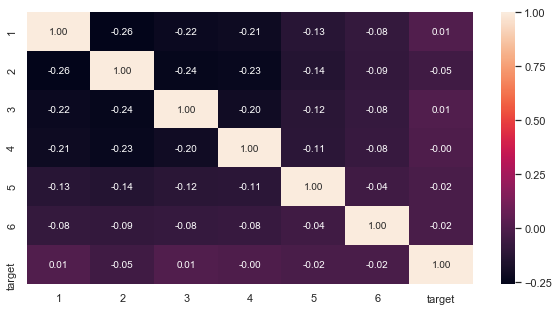

In [46]:
tmp = pd.get_dummies(full_df[:train_idx]['time1'].dt.weekday, drop_first=True)
X_train = pd.concat([tmp, y_train], axis=1)

plt.figure(figsize=(10,5))
sns.heatmap(X_train.corr(), annot=True, fmt='.2f')
plt.show()

In [47]:
def add_week_day(ts, X_sparse):
    tmp = pd.get_dummies(ts.dt.weekday, drop_first=True)
    cols = np.arange(2,8)
    tmp = tmp.T.reindex(cols).T.fillna(0).astype(int).values
    return hstack([tmp, X_sparse])

In [48]:
X_train = cv_full_sparse[:train_idx]
X_train = add_hours(full_df[:train_idx]['time1'], X_train)
X_train = add_cyclic(full_df[:train_idx]['time1'], X_train)
X_train = add_active_hours(full_df[:train_idx]['time1'], X_train)
X_train = add_session_length(full_df[:train_idx][times], X_train)
X_train = add_session_std(full_df[:train_idx][times], X_train)
X_train = add_active_week_day(full_df[:train_idx]['time1'], X_train)
X_train = add_week_day(full_df[:train_idx]['time1'], X_train)
def_score7t = cross_val_score(lr, X_train, y_train, cv=tsf, scoring='roc_auc', n_jobs=-1).mean()
def_score7s = cross_val_score(lr, X_train, y_train, cv=skf, scoring='roc_auc', n_jobs=-1).mean()
print('ROC-AUC for baseline model:          ', np.mean([def_score6s, def_score6t]))
print('ROC-AUC with time-series split:      ', def_score7t)
print('ROC-AUC with stratified k-fold split:', def_score7s)
print('ROC-AUC mean:                        ', np.mean([def_score7t, def_score7s]))


ROC-AUC for baseline model:           0.9379205427904604
ROC-AUC with time-series split:       0.913744556767518
ROC-AUC with stratified k-fold split: 0.9499671122267742
ROC-AUC mean:                         0.9318558344971462


In [49]:
del tmp, X_train

`week_day` feature decreased our model performance. __TODO__: try submitting with and without this feature.

__NOTE__: since adding informative (_that is if applied solo increases model quality_) feature to LR the decrease in metric here can be explained by the fact that this model just improved its generalization. But it should be noted that it might as well add some variativity to our dataset, thus decreasing the metric. In short, it is very complicated.

### Feature on month

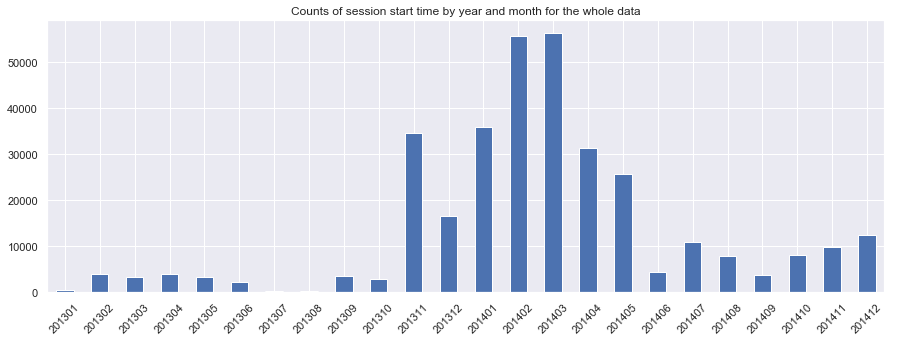

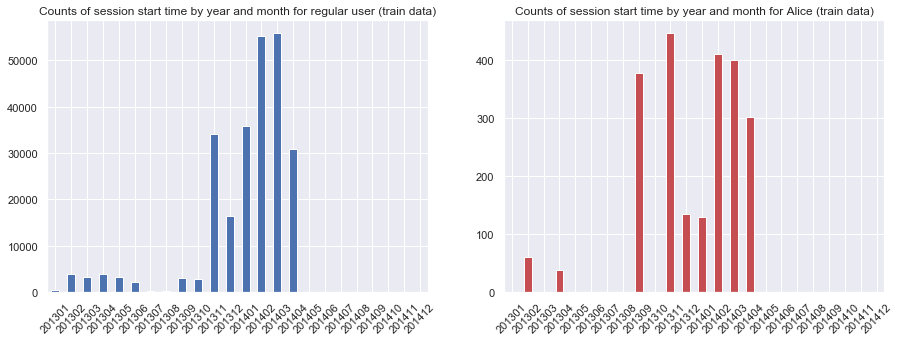

In [50]:
tmp = pd.get_dummies(full_df['time1'].dt.year.apply(str) + \
                     full_df['time1'].dt.month.apply(lambda x: str(x) if x>9 else '0'+str(x)))

plt.figure(figsize=(15,5))
tmp.sum().plot(kind='bar', color='b', rot=45)
plt.title('Counts of session start time by year and month for the whole data')
plt.show()

plt.subplots(1,2, figsize=(15,5))
axes=plt.gcf().get_axes()
tmp[:train_idx][y_train==0].sum().plot(kind='bar', color='b', rot=45, ax=axes[0])
tmp[:train_idx][y_train==1].sum().plot(kind='bar', color='r', rot=45, ax=axes[1])
axes[0].set_title('Counts of session start time by year and month for regular user (train data)')
axes[1].set_title('Counts of session start time by year and month for Alice (train data)')
plt.show()

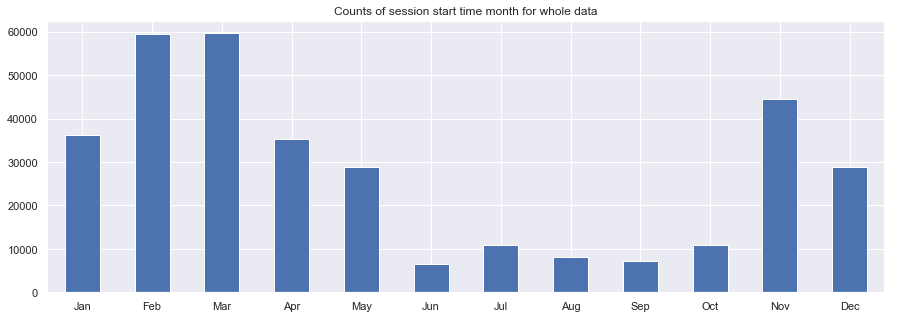

In [51]:
tmp = pd.get_dummies(full_df['time1'].dt.month)

plt.figure(figsize=(15,5))
tmp.sum().plot(kind='bar', color='b', rot=0)
plt.xticks(ticks=range(0,12), labels=[calendar.month_abbr[i] for i in range(1,13)])
plt.title('Counts of session start time month for whole data')
plt.show()

In [52]:
def add_month_dummy(ts, X_sparse):
    tmp = pd.get_dummies(ts.dt.month, drop_first=True)
    cols = np.arange(2,13)
    tmp = tmp.T.reindex(cols).T.fillna(0).astype(int).values
    return hstack([tmp, X_sparse])

In [53]:
X_train = cv_full_sparse[:train_idx]
X_train = add_hours(full_df[:train_idx]['time1'], X_train)
X_train = add_cyclic(full_df[:train_idx]['time1'], X_train)
X_train = add_active_hours(full_df[:train_idx]['time1'], X_train)
X_train = add_session_length(full_df[:train_idx][times], X_train)
X_train = add_session_std(full_df[:train_idx][times], X_train)
X_train = add_active_week_day(full_df[:train_idx]['time1'], X_train)
X_train = add_week_day(full_df[:train_idx]['time1'], X_train)
X_train = add_month_dummy(full_df[:train_idx]['time1'], X_train)
def_score8t = cross_val_score(lr, X_train, y_train, cv=tsf, scoring='roc_auc', n_jobs=-1).mean()
def_score8s = cross_val_score(lr, X_train, y_train, cv=skf, scoring='roc_auc', n_jobs=-1).mean()
print('ROC-AUC for baseline model:          ', np.mean([def_score7s, def_score7t]))
print('ROC-AUC with time-series split:      ', def_score8t)
print('ROC-AUC with stratified k-fold split:', def_score8s)
print('ROC-AUC mean:                        ', np.mean([def_score8t, def_score8s]))


ROC-AUC for baseline model:           0.9318558344971462
ROC-AUC with time-series split:       0.9192038846839553
ROC-AUC with stratified k-fold split: 0.919228241450077
ROC-AUC mean:                         0.9192160630670161


In [54]:
del tmp, axes, X_train

### Cyclic day of year feature (sin- and cos-transformations)

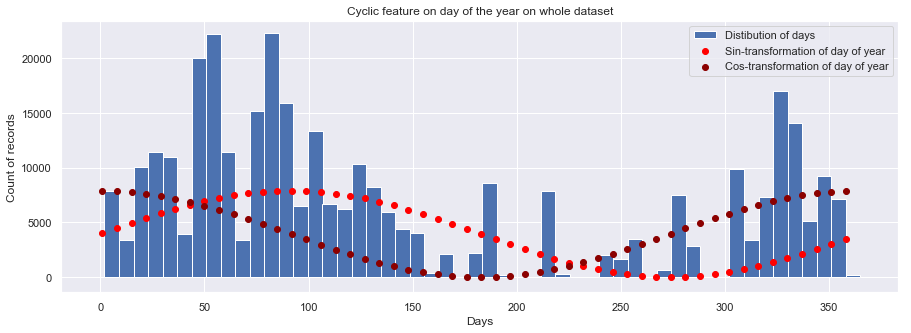

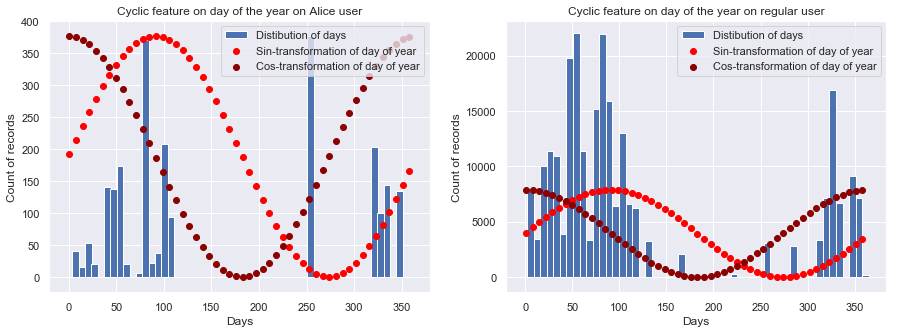

In [55]:
tmp = full_df['time1'].dt.dayofyear
mx = tmp.value_counts().max()

days =  np.arange(1,365,7)
plt.figure(figsize=(15,5))
plt.hist(tmp, bins=365//7, width=7, color='b', label='Distibution of days', zorder=1)
plt.scatter(days, np.sin(2*np.pi*days/365)*mx/2 + mx/2, label='Sin-transformation of day of year', 
            c='#FF0000', zorder=2)
plt.scatter(days, np.cos(2*np.pi*days/365)*mx/2 + mx/2, label='Cos-transformation of day of year', 
            c='#8B0000', zorder=3)
plt.legend(loc='upper right')
plt.title('Cyclic feature on day of the year on whole dataset')
plt.xlabel('Days')
plt.ylabel('Count of records')
plt.show()

tmpA = tmp[:train_idx][y_train==1]
mx = tmpA.value_counts().max()

plt.figure(figsize=(15,5))
plt.subplot('121')
plt.hist(tmpA, bins=365//7, width=7, color='b', label='Distibution of days', zorder=1)
plt.scatter(days, np.sin(2*np.pi*days/365)*mx/2 + mx/2, label='Sin-transformation of day of year', 
            c='#FF0000', zorder=2)
plt.scatter(days, np.cos(2*np.pi*days/365)*mx/2 + mx/2, label='Cos-transformation of day of year', 
            c='#8B0000', zorder=3)
plt.legend(loc='upper right')
plt.title('Cyclic feature on day of the year on Alice user')
plt.xlabel('Days')
plt.ylabel('Count of records')

tmpR = tmp[:train_idx][y_train==0]
mx = tmpR.value_counts().max()

plt.subplot('122')
plt.hist(tmpR, bins=365//7, width=7, color='b', label='Distibution of days', zorder=1)
plt.scatter(days, np.sin(2*np.pi*days/365)*mx/2 + mx/2, label='Sin-transformation of day of year', 
            c='#FF0000', zorder=2)
plt.scatter(days, np.cos(2*np.pi*days/365)*mx/2 + mx/2, label='Cos-transformation of day of year', 
            c='#8B0000', zorder=3)
plt.legend(loc='upper right')
plt.title('Cyclic feature on day of the year on regular user')
plt.xlabel('Days')
plt.ylabel('Count of records')
plt.show()

In [56]:
def add_cyclic_dayofyear(ts, X_sparse):
    tmp = ts.dt.dayofyear
    sin = np.sin(2*np.pi*tmp/365).values.reshape((-1,1))
    cos = np.cos(2*np.pi*tmp/365).values.reshape((-1,1))
    return hstack([sin, cos, X_sparse])

In [57]:
X_train = cv_full_sparse[:train_idx]
X_train = add_hours(full_df[:train_idx]['time1'], X_train)
X_train = add_cyclic(full_df[:train_idx]['time1'], X_train)
X_train = add_active_hours(full_df[:train_idx]['time1'], X_train)
X_train = add_session_length(full_df[:train_idx][times], X_train)
X_train = add_session_std(full_df[:train_idx][times], X_train)
X_train = add_active_week_day(full_df[:train_idx]['time1'], X_train)
X_train = add_week_day(full_df[:train_idx]['time1'], X_train)
X_train = add_month_dummy(full_df[:train_idx]['time1'], X_train)
X_train = add_cyclic_dayofyear(full_df[:train_idx]['time1'], X_train)
def_score9t = cross_val_score(lr, X_train, y_train, cv=tsf, scoring='roc_auc', n_jobs=-1).mean()
def_score9s = cross_val_score(lr, X_train, y_train, cv=skf, scoring='roc_auc', n_jobs=-1).mean()
print('ROC-AUC for baseline model:          ', np.mean([def_score8s, def_score8t]))
print('ROC-AUC with time-series split:      ', def_score9t)
print('ROC-AUC with stratified k-fold split:', def_score9s)
print('ROC-AUC mean:                        ', np.mean([def_score9t, def_score9s]))

ROC-AUC for baseline model:           0.9192160630670161
ROC-AUC with time-series split:       0.9198425167729454
ROC-AUC with stratified k-fold split: 0.9171480228356967
ROC-AUC mean:                         0.9184952698043211


In [59]:
del tmp, tmpA, tmpR, days, mx, X_train

NameError: name 'tmp' is not defined

***
### Tests of features

Let's now check all newly generated features one by one if it improves the metric.

In [60]:
tmpFull = full_df[:train_idx][times]
tmp = full_df[:train_idx]['time1']

tmp1 = tmp.dt.hour*60 + tmp.dt.minute
cos = np.cos(2*np.pi*tmp1/(16*60)).values
sin = np.sin(2*np.pi*tmp1/(16*60)).values
X_train = np.stack([cos, sin], axis=1)
print('Score with cyclic features (tsf):           ', cross_val_score(lr, X_train, y_train, cv=tsf, 
                                                    scoring='roc_auc', n_jobs=-1).mean())

print('Score with cyclic features (skf):           ', cross_val_score(lr, X_train, y_train, cv=skf, 
                                                    scoring='roc_auc', n_jobs=-1).mean())
print()

tmp1 = tmp.dt.hour
active1 = ((tmp1>=12) & (tmp1<=13)).astype(int).values
active2 = ((tmp1>=16) & (tmp1<=18)).astype(int).values
active3 = (((tmp1>=7) & (tmp1<=11))|((tmp1>=14) & (tmp1<=15))).astype(int).values
X_train = np.stack([active1, active2, active3], axis=1)
print('Score with active hours features (tsf):     ', cross_val_score(lr, X_train, y_train, cv=tsf, 
                                                    scoring='roc_auc', n_jobs=-1).mean())
print('Score with active hours features (skf):     ', cross_val_score(lr, X_train, y_train, cv=skf, 
                                                    scoring='roc_auc', n_jobs=-1).mean())
print()

X_train = pd.get_dummies(tmp.dt.hour, drop_first=True)
print('Score with dummy hours features (tsf):      ', cross_val_score(lr, X_train, y_train, cv=tsf, 
                                                    scoring='roc_auc', n_jobs=-1).mean())
print('Score with dummy hours features (skf):      ', cross_val_score(lr, X_train, y_train, cv=skf, 
                                                    scoring='roc_auc', n_jobs=-1).mean())
print()

tmp1 = ((tmpFull.max(axis=1)-tmpFull.min(axis=1))/pd.Timedelta(minutes=1)).values
X_train = StandardScaler().fit_transform(tmp1.reshape(-1,1))
print('Score with session length feature (tsf):    ', cross_val_score(lr, X_train, y_train, cv=tsf, 
                                                    scoring='roc_auc', n_jobs=-1).mean())
print('Score with session length feature (skf):    ', cross_val_score(lr, X_train, y_train, cv=skf, 
                                                    scoring='roc_auc', n_jobs=-1).mean())
print()
    
tmp1 = tmpFull.applymap(lambda x: x if pd.isna(x) else x.value/1000000000).std(axis=1).fillna(0)
tmp1 = tmp1 + 1
tmp1 = tmp1.apply(np.log)
X_train = StandardScaler().fit_transform(tmp1.values.reshape((-1,1)))
# X_train = tmp1.values.astype('float64').reshape((-1,1))
print('Score with std. of session feature (tsf):   ', cross_val_score(lr, X_train, y_train, cv=tsf, 
                                                    scoring='roc_auc', n_jobs=-1).mean())
print('Score with std. of session feature (skf):   ', cross_val_score(lr, X_train, y_train, cv=skf, 
                                                    scoring='roc_auc', n_jobs=-1).mean())
print()

tmp1 = tmp.dt.weekday
X_train = (((tmp1>=0) & (tmp1<=1))|((tmp1>=3) & (tmp1<=4))).astype(int).values.reshape((-1,1))
print('Score with active week day feature (tsf):   ', cross_val_score(lr, X_train, y_train, cv=tsf, 
                                                    scoring='roc_auc', n_jobs=-1).mean())
print('Score with active week day feature (skf):   ', cross_val_score(lr, X_train, y_train, cv=skf, 
                                                    scoring='roc_auc', n_jobs=-1).mean())
print()

X_train = pd.get_dummies(tmp1, drop_first=True)
print('Score with dummy week day feature (tsf):    ', cross_val_score(lr, X_train, y_train, cv=tsf, 
                                                    scoring='roc_auc', n_jobs=-1).mean())
print('Score with dummy week day feature (skf):    ', cross_val_score(lr, X_train, y_train, cv=skf, 
                                                    scoring='roc_auc', n_jobs=-1).mean())
print()

X_train = pd.get_dummies(tmp.dt.month, drop_first=True)
print('Score with dummy month feature (tsf):       ', cross_val_score(lr, X_train, y_train, cv=tsf, 
                                                    scoring='roc_auc', n_jobs=-1).mean())
print('Score with dummy month feature (skf):       ', cross_val_score(lr, X_train, y_train, cv=skf, 
                                                    scoring='roc_auc', n_jobs=-1).mean())
print()

tmp1 = tmp.dt.dayofyear
sin = np.sin(2*np.pi*tmp1/365).values
cos = np.cos(2*np.pi*tmp1/365).values
X_train = np.stack([sin, cos], axis=1)
print('Score with cyclic day of year feature (tsf):', cross_val_score(lr, X_train, y_train, cv=tsf, 
                                                    scoring='roc_auc', n_jobs=-1).mean())
print('Score with cyclic day of year feature (skf):', cross_val_score(lr, X_train, y_train, cv=skf, 
                                                    scoring='roc_auc', n_jobs=-1).mean())
print()

    

Score with cyclic features (tsf):            0.845637180084703
Score with cyclic features (skf):            0.8291435876855984

Score with active hours features (tsf):      0.8059392924374992
Score with active hours features (skf):      0.8772075441969835

Score with dummy hours features (tsf):       0.8374947170744
Score with dummy hours features (skf):       0.8715561427387296

Score with session length feature (tsf):     0.6105835469170676
Score with session length feature (skf):     0.6118442265313583

Score with std. of session feature (tsf):    0.6081550806225546
Score with std. of session feature (skf):    0.6120228001211722

Score with active week day feature (tsf):    0.6031249434382745
Score with active week day feature (skf):    0.6398214564280382

Score with dummy week day feature (tsf):     0.5925319399426251
Score with dummy week day feature (skf):     0.6030032962597758

Score with dummy month feature (tsf):        0.5195283177678097
Score with dummy month feature (skf):

In [61]:
del tmpFull, tmp, tmp1, cos, sin, active1, active2, active3, X_train

### Correlation of features
Let's check the correlation of newly generated features.

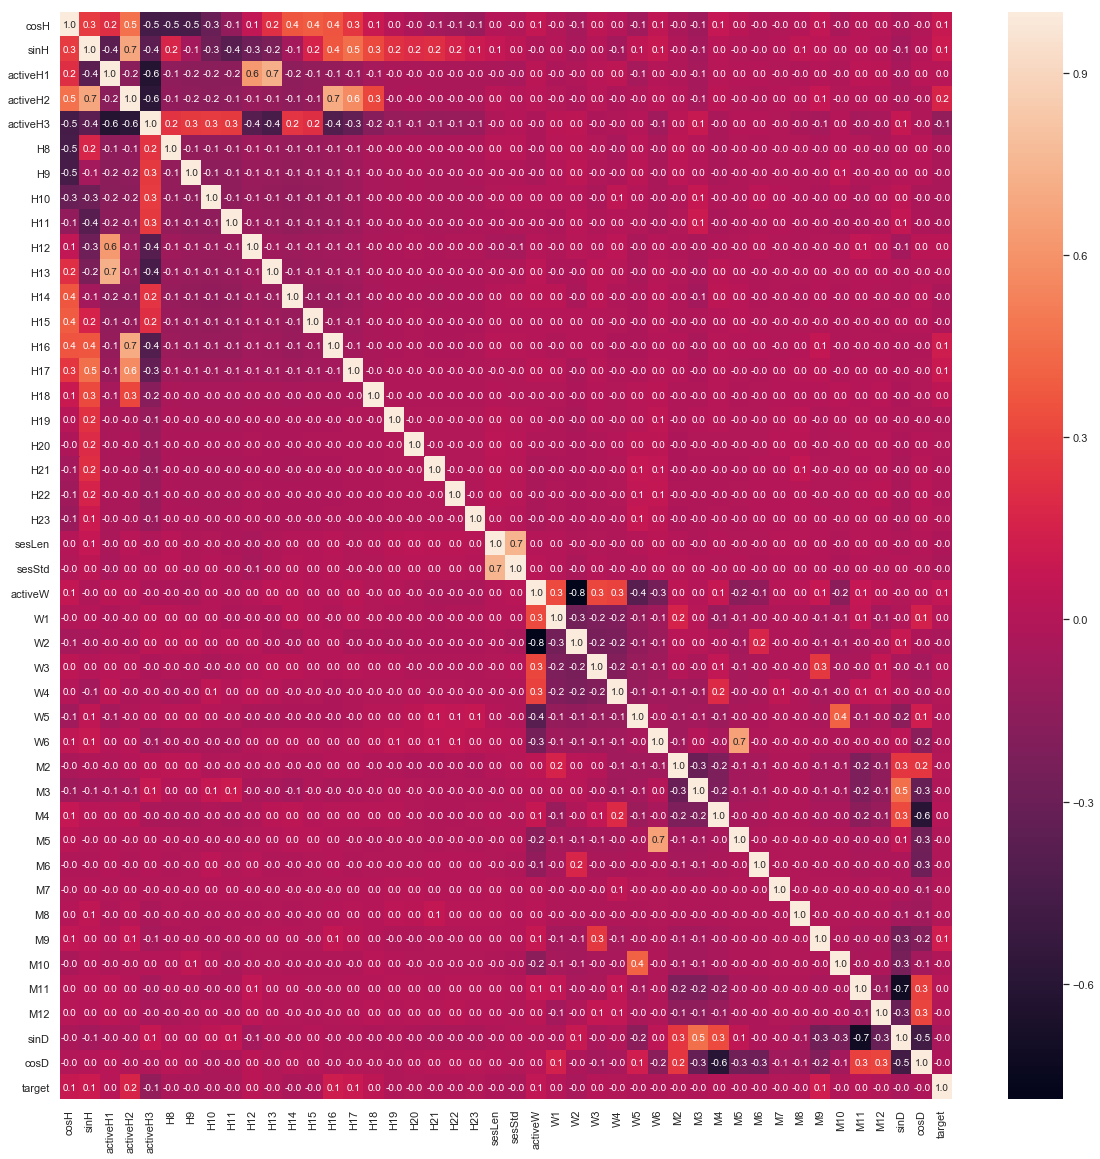

In [62]:
tmpFull = full_df[:train_idx][times]
tmp = full_df[:train_idx]['time1']

tmp1 = tmp.dt.hour*60 + tmp.dt.minute
cosH = np.cos(2*np.pi*tmp1/(16*60)).rename('cosH')
sinH = np.sin(2*np.pi*tmp1/(16*60)).rename('sinH')

tmp1 = tmp.dt.hour
activeH1 = ((tmp1>=12) & (tmp1<=13)).astype(int).rename('activeH1')
activeH2 = ((tmp1>=16) & (tmp1<=18)).astype(int).rename('activeH2')
activeH3 = (((tmp1>=7) & (tmp1<=11))|((tmp1>=14) & (tmp1<=15))).astype(int).rename('activeH3')

activeH = pd.get_dummies(tmp1, drop_first=True) \
        .rename(columns = dict(zip(range(8, 24), ['H'+str(i) for i in range(8,24)])))

tmp1 = ((tmpFull.max(axis=1)-tmpFull.min(axis=1))/pd.Timedelta(minutes=1))
sesLen = pd.Series(StandardScaler().fit_transform(tmp1.values.reshape((-1,1))).flatten(), 
                   index=tmp1.index, name='sesLen')
    
tmp1 = tmpFull.applymap(lambda x: x if pd.isna(x) else x.value/1000000000).std(axis=1).fillna(0)
tmp1 = tmp1.apply(np.log1p)
sesStd = pd.Series(StandardScaler().fit_transform(tmp1.values.reshape((-1,1))).flatten(),
                   index=tmp1.index, name='sesStd')

tmp1 = tmp.dt.weekday
activeW1 = (((tmp1>=0) & (tmp1<=1))|((tmp1>=3) & (tmp1<=4))).astype(int).rename('activeW')

activeW = pd.get_dummies(tmp1, drop_first=True) \
        .rename(columns = dict(zip(range(1, 7), ['W'+str(i) for i in range(1,7)])))

month = pd.get_dummies(tmp.dt.month, drop_first=True) \
        .rename(columns = dict(zip(range(1,13), ['M'+str(i) for i in range(1,13)])))

tmp1 = tmp.dt.dayofyear
sinD = np.sin(2*np.pi*tmp1/365).rename('sinD')
cosD = np.cos(2*np.pi*tmp1/365).rename('cosD')

X_train = pd.concat([cosH, sinH, activeH1, activeH2, activeH3, activeH, sesLen, sesStd, 
                     activeW1, activeW, month, sinD, cosD, y_train], axis=1)

plt.figure(figsize=(20,20))
sns.heatmap(X_train.corr(), annot=True, fmt='.1f')
plt.xticks(rotation=90)
plt.show()

***
### Testing feature selection with Lasso

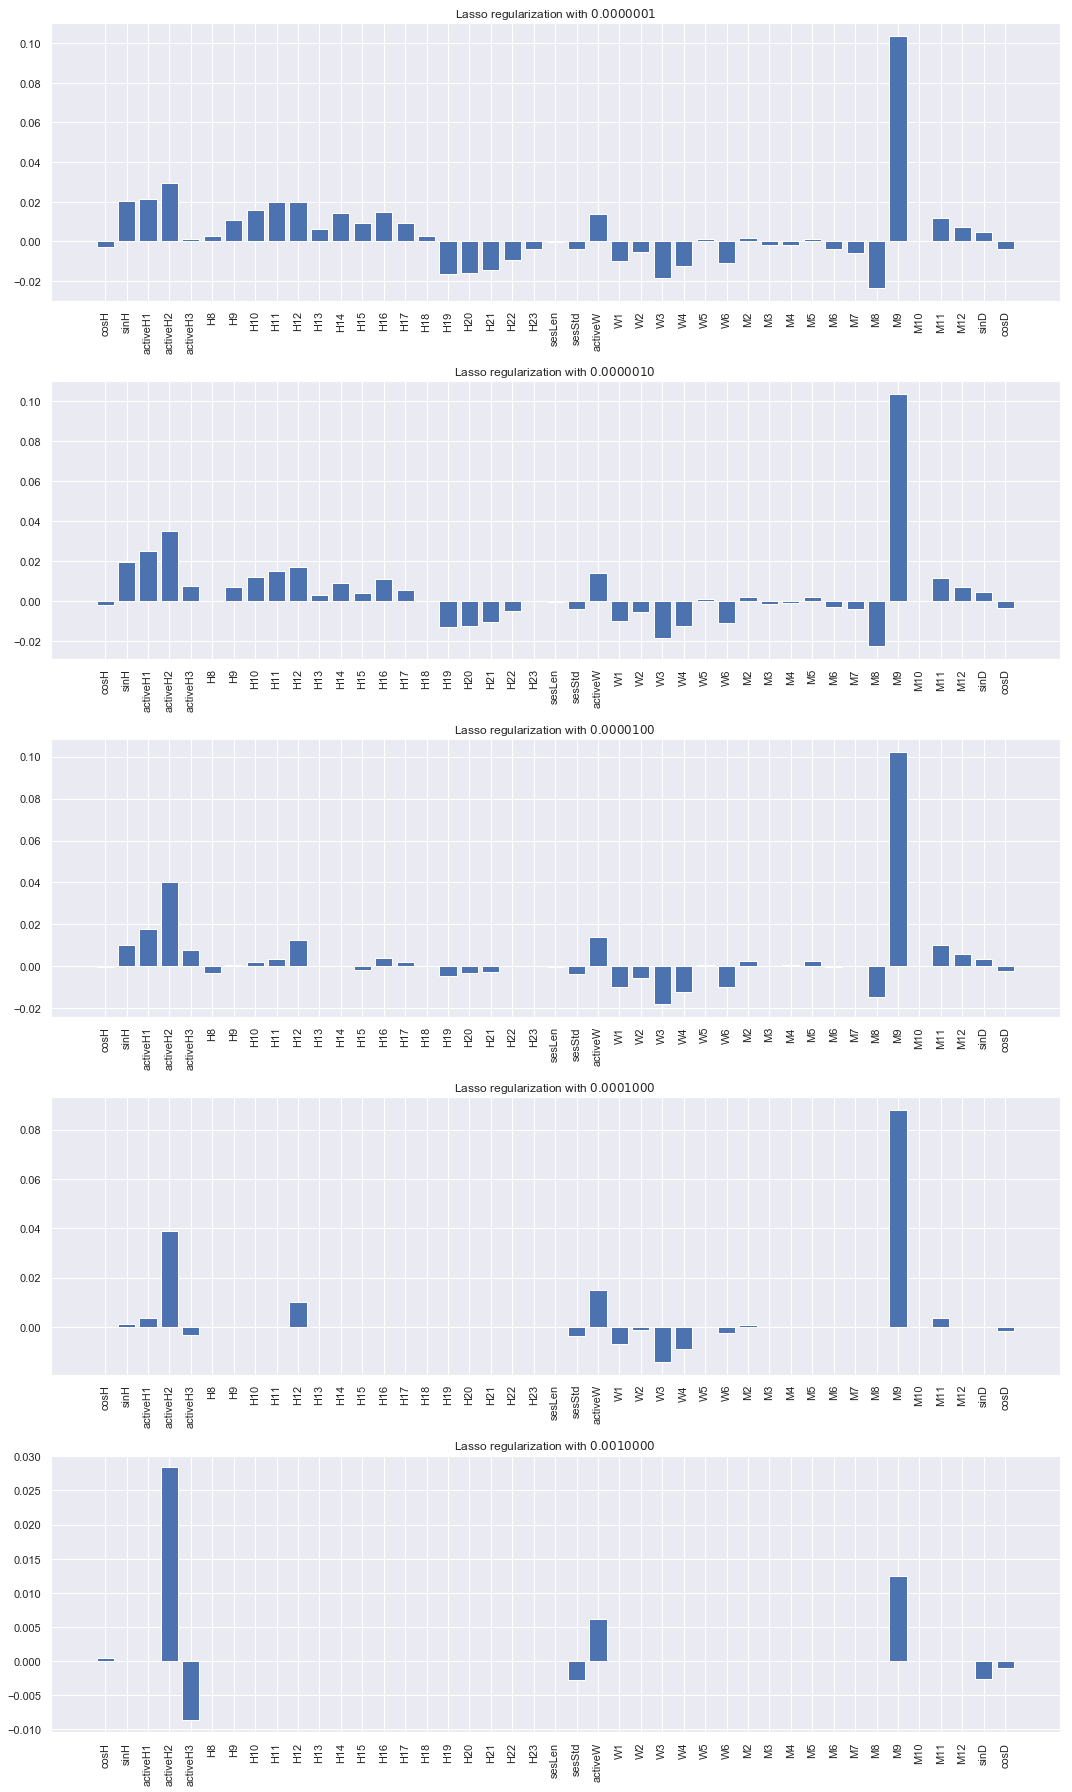

In [63]:
from sklearn.linear_model import Lasso

plt.figure(figsize=(15,25))

a_values = np.logspace(-7,-3, 5)
X_train = X_train.drop('target', axis=1)

for i in range(0,5):
    plt.subplot('51'+str(i+1))
    l = Lasso(alpha=a_values[i])
    l.fit(X_train, y_train)
    plt.bar(X_train.columns, l.coef_)
    plt.title("Lasso regularization with $%.7f$" % a_values[i])
    plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

### And Ridge (for comparison)

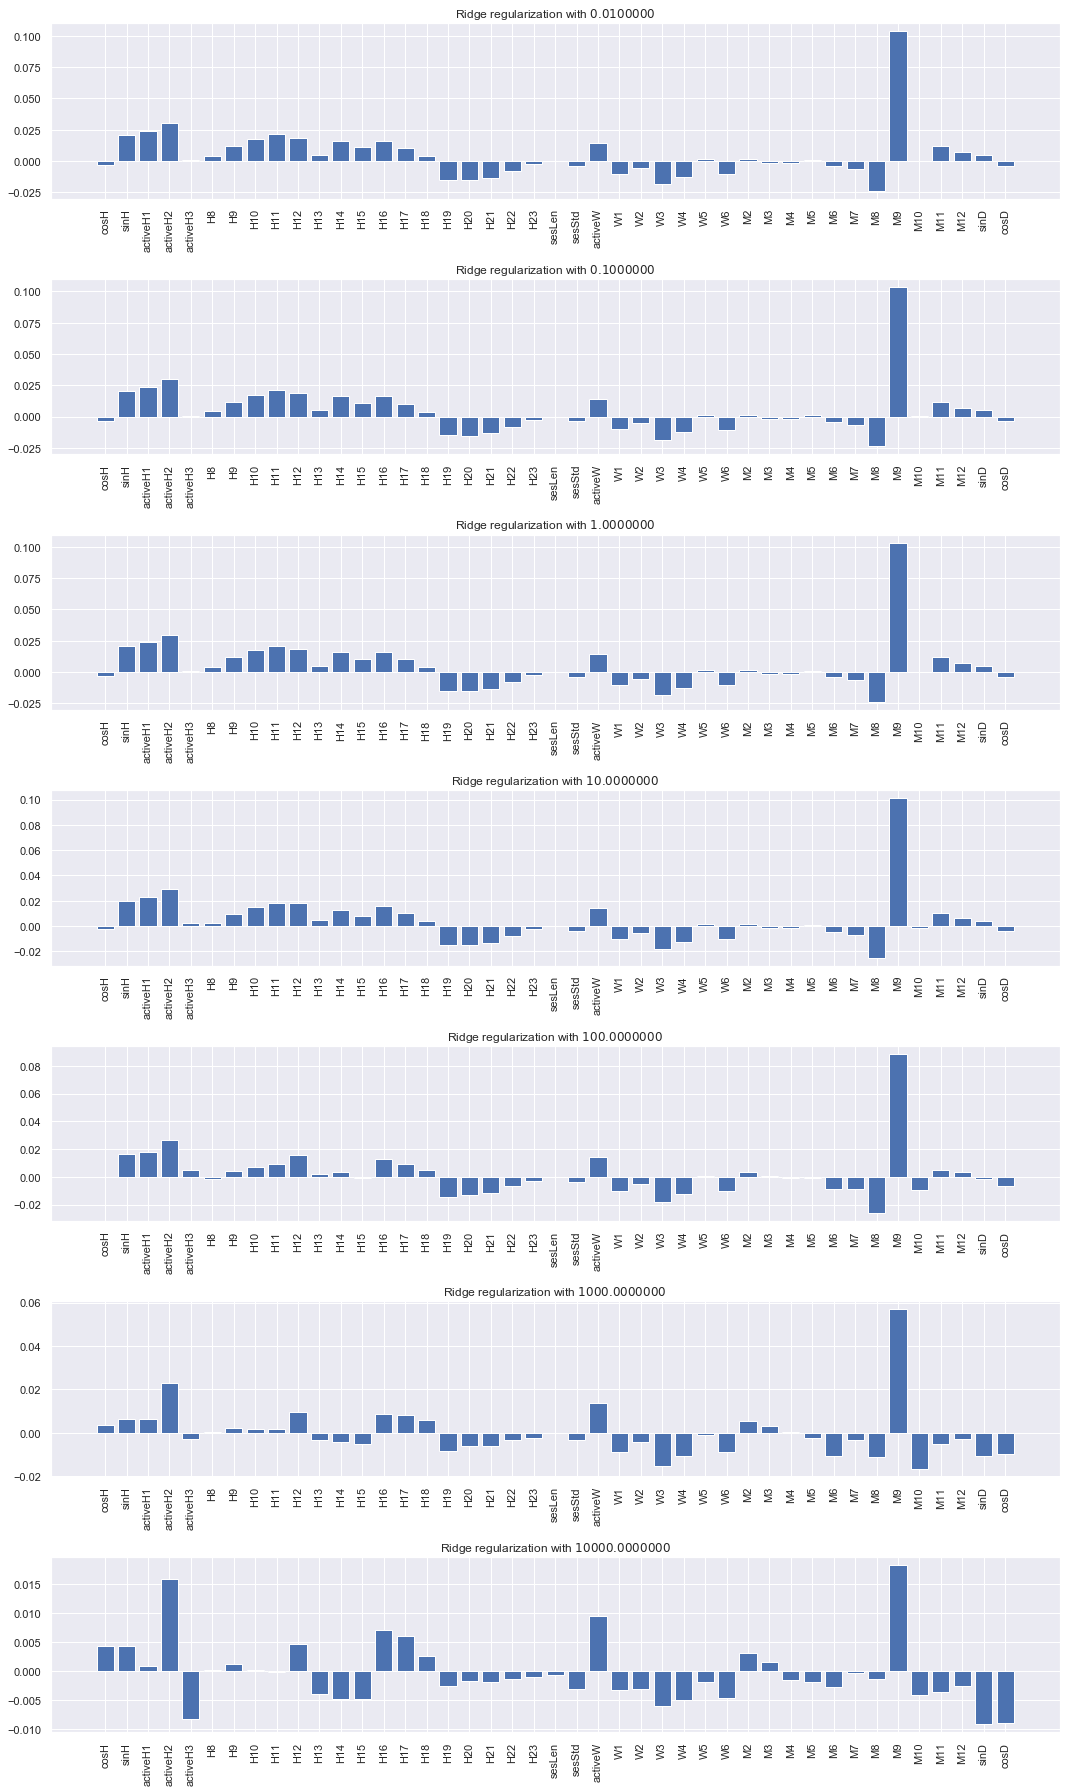

In [64]:
from sklearn.linear_model import Ridge

plt.figure(figsize=(15,25))

a_values = np.logspace(-2,4, 7)

for i in range(0,7):
    plt.subplot('71'+str(i+1))
    r = Ridge(alpha=a_values[i])
    r.fit(X_train, y_train)
    plt.bar(X_train.columns, r.coef_)
    plt.title("Ridge regularization with $%.7f$" % a_values[i])
    plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

In [65]:
del tmpFull, tmp, tmp1, cosH, sinH, activeH1, activeH2, activeH3, activeH 
del sesLen, sesStd, activeW1, activeW, month, sinD, cosD, X_train, a_values

***
### Hyperparameter tuning

In [66]:
X_train = cv_full_sparse[:train_idx]
X_train = add_hours(full_df[:train_idx]['time1'], X_train)
X_train = add_cyclic(full_df[:train_idx]['time1'], X_train)
X_train = add_active_hours(full_df[:train_idx]['time1'], X_train)
X_train = add_session_length(full_df[:train_idx][times], X_train)
X_train = add_session_std(full_df[:train_idx][times], X_train)
X_train = add_active_week_day(full_df[:train_idx]['time1'], X_train)
X_train = add_week_day(full_df[:train_idx]['time1'], X_train)
X_train = add_month_dummy(full_df[:train_idx]['time1'], X_train)
X_train = add_cyclic_dayofyear(full_df[:train_idx]['time1'], X_train)

lrN = LogisticRegression(solver='lbfgs', max_iter=200)
C_values = np.logspace(-2, -6, 10, base=2)

lrGSt = GridSearchCV(lrN, param_grid={'C': C_values}, 
                    scoring='roc_auc', n_jobs=-1, cv=tsf, verbose=1)
lrGSt.fit(X_train, y_train)


lrGSs = GridSearchCV(lrN, param_grid={'C': C_values}, 
                    scoring='roc_auc', n_jobs=-1, cv=skf, verbose=1)
lrGSs.fit(X_train, y_train)

print('Best score with C = {:.5f} and time-aware CV is        {:.5f}'.format(
    lrGSt.best_params_['C'], lrGSt.best_score_))
print('Best score with C = {:.5f} and stratified K-fold CV is {:.5f}'.format(
    lrGSs.best_params_['C'], lrGSs.best_score_))

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.7min finished


Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  7.7min finished


Best score with C = 0.18372 and time-aware CV is        0.92097
Best score with C = 0.02126 and stratified K-fold CV is 0.93379


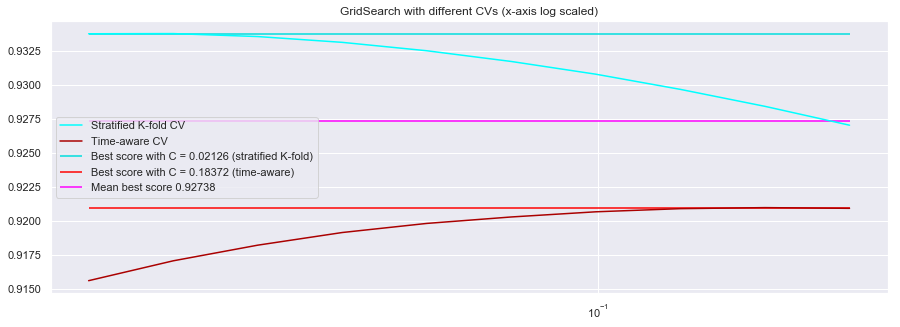

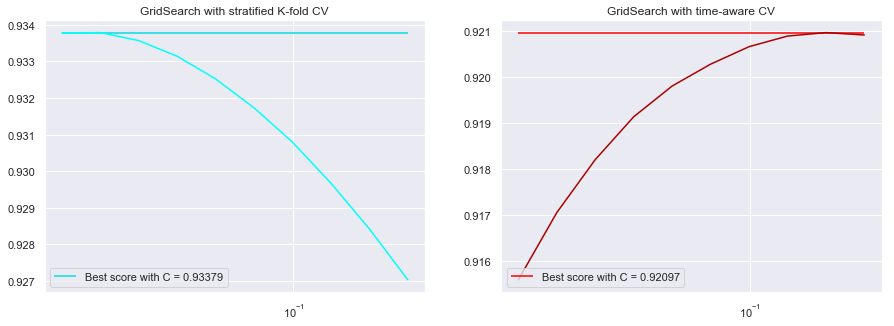

In [67]:
plt.figure(figsize=(15,5))
plt.title('GridSearch with different CVs (x-axis log scaled)')
plt.plot([lrGSs.cv_results_['params'][i]['C'] for i in range(0,10)], lrGSs.cv_results_['mean_test_score'],
         label='Stratified K-fold CV', c='#00ffff')
plt.hlines(lrGSs.best_score_, C_values.min(), C_values.max(), color='#00dddd',
           label='Best score with C = {:.5f} (stratified K-fold)'.format(lrGSs.best_params_['C']))
plt.plot([lrGSt.cv_results_['params'][i]['C'] for i in range(0,10)], lrGSt.cv_results_['mean_test_score'],
         label='Time-aware CV', c='#aa0000')
plt.hlines(lrGSt.best_score_, C_values.min(), C_values.max(), color='#ff0000',
           label='Best score with C = {:.5f} (time-aware)'.format(lrGSt.best_params_['C']))
plt.hlines(np.mean([lrGSt.best_score_, lrGSs.best_score_]), C_values.min(), C_values.max(), color='#FF00FF',
           label='Mean best score {:.5f}'.format(np.mean([lrGSt.best_score_, lrGSs.best_score_])))
plt.xscale('log')
plt.legend(loc='center left')
plt.figure(figsize=(15,5))
plt.subplot('121')
plt.title('GridSearch with stratified K-fold CV')
plt.plot([lrGSs.cv_results_['params'][i]['C'] for i in range(0,10)], lrGSs.cv_results_['mean_test_score'],
         c='#00ffff')
plt.hlines(lrGSs.best_score_, C_values.min(), C_values.max(), color='#00dddd',
           label='Best score with C = {:.5f}'.format(lrGSs.best_score_))
plt.xscale('log')
plt.legend(loc='lower left')
plt.subplot('122')
plt.title('GridSearch with time-aware CV')
plt.plot([lrGSt.cv_results_['params'][i]['C'] for i in range(0,10)], lrGSt.cv_results_['mean_test_score'],
         c='#aa0000')
plt.hlines(lrGSt.best_score_, C_values.min(), C_values.max(), color='#ff0000',
           label='Best score with C = {:.5f}'.format(lrGSt.best_score_))
plt.xscale('log')
plt.legend(loc='lower left')
plt.show()

***

### Submission

In [73]:
from sklearn.metrics import confusion_matrix

predictedT = pd.Series(lrGSt.predict(X_train), name='Predicted (time)')
predictedS = pd.Series(lrGSs.predict(X_train), name='Predicted (k-fold)')

In [74]:
print('Confusion matrix by time-aware CV')
pd.crosstab(y_train, predictedT, rownames=['TrueT'], colnames=['PredictedT'])

Confusion matrix by time-aware CV


PredictedT,0,1
TrueT,,
0,249773,2283
1,1490,14


In [75]:
print('Confusion matrix by statified CV')
pd.crosstab(y_train, predictedS, rownames=['TrueS'], colnames=['PredictedS'])

Confusion matrix by statified CV


PredictedS,0,1
TrueS,,
0,250551,2288
1,712,9


In [76]:
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [77]:
X_test = cv_full_sparse[train_idx:]
X_test = add_hours(full_df[train_idx:]['time1'], X_test)
X_test = add_cyclic(full_df[train_idx:]['time1'], X_test)
X_test = add_active_hours(full_df[train_idx:]['time1'], X_test)
X_test = add_session_length(full_df[train_idx:][times], X_test)
X_test = add_session_std(full_df[train_idx:][times], X_test)
X_test = add_active_week_day(full_df[train_idx:]['time1'], X_test)
X_test = add_week_day(full_df[train_idx:]['time1'], X_test)
X_test = add_month_dummy(full_df[train_idx:]['time1'], X_test)
X_test = add_cyclic_dayofyear(full_df[train_idx:]['time1'], X_test)

y_pred = lrGSt.predict_proba(X_test)[:,1]
write_to_submission_file(y_pred, './statics/submS.csv')

In [ ]:
del X_train, lrGNt, lrGSs, c_values, predictedS, predictedT, X_test, lrN, y_pred

***
### Important regarding slicing through `loc`, slicing through parentheses, and `iloc`

In [28]:
print(full_df['time1'].iloc[train_idx:].shape)
print(full_df.loc[train_idx:, 'time1'].shape)
print(full_df['time1'][train_idx:].shape)
print(csr_full_sparse[train_idx:, :].shape)

(82797,)
(82798,)
(82797,)
(82797, 48371)


So, when using `loc`, it explicitly selects by label, i.e. index here (inclusive - inclusive), whereas `iloc` selects by position (inclusive - inclusive).

In [29]:
full_df['time1'].iloc[train_idx-1:train_idx+2]

session_id
253561   2014-04-25 09:56:52
1        2014-10-04 11:19:53
2        2014-07-03 11:00:28
Name: time1, dtype: datetime64[ns]

In [30]:
full_df.loc[train_idx:, 'time1'].head()

session_id
253561   2014-04-25 09:56:52
1        2014-10-04 11:19:53
2        2014-07-03 11:00:28
3        2014-12-05 15:55:12
4        2014-11-04 10:03:19
Name: time1, dtype: datetime64[ns]

In [31]:
full_df[train_idx-1:train_idx+2]['time1']

session_id
253561   2014-04-25 09:56:52
1        2014-10-04 11:19:53
2        2014-07-03 11:00:28
Name: time1, dtype: datetime64[ns]

***
### NOTE REGARDING SHELL OPERATIONS:

Any command that works at the command-line can be used in IPython by prefixing it with the __! character__. For example, the ls, pwd, and echo commands can be run as follows:

In [186]:
!head -5 ./statics/train_sessions_text.txt

56 55 0 0 0 0 0 0 0 0
56 55 56 55 0 0 0 0 0 0
946 946 951 946 946 945 948 784 949 946
945 948 949 948 945 946 947 945 946 946
947 950 948 947 950 952 946 951 946 947


***
## New sparse vector - TF-IDF on csr_matrix

In [78]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf = TfidfTransformer()
tfidf_full_sparse = tfidf.fit_transform(cv_full_sparse[:train_idx, :])
tfidf_full_sparse = vstack([tfidf_full_sparse, tfidf.transform(cv_full_sparse[train_idx:, :])])
tfidf_full_sparse.shape, tfidf_full_sparse[:train_idx,:].shape, tfidf_full_sparse[train_idx:, :].shape

((336358, 100000), (253561, 100000), (82797, 100000))

Let's find the best features for `TF-IDF`. Since original `CountVectorizer` and `TF-IDF` are different matrixes, this might require different settings for the features. Let's tackle this iteratively, by adding one feature at a time.

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  8.9min finished


Best score with C = 6.85795 and time-aware CV is        0.90379


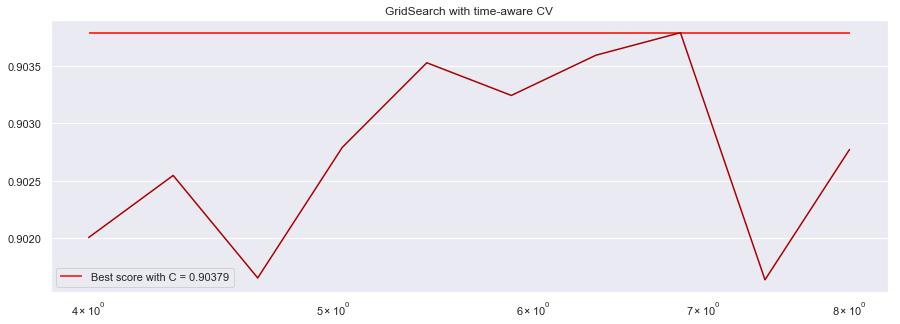

In [79]:
X_train = tfidf_full_sparse[:train_idx]
X_train = add_hours(full_df[:train_idx]['time1'], X_train)
X_train = add_cyclic(full_df[:train_idx]['time1'], X_train)
X_train = add_active_hours(full_df[:train_idx]['time1'], X_train)
X_train = add_session_length(full_df[:train_idx][times], X_train)
X_train = add_session_std(full_df[:train_idx][times], X_train)
X_train = add_active_week_day(full_df[:train_idx]['time1'], X_train)
X_train = add_week_day(full_df[:train_idx]['time1'], X_train)
X_train = add_month_dummy(full_df[:train_idx]['time1'], X_train)
X_train = add_cyclic_dayofyear(full_df[:train_idx]['time1'], X_train)

lrN = LogisticRegression(solver='lbfgs', max_iter=200)
C_valuesT = np.logspace(3, 2, 10, base=2)

lrGSt = GridSearchCV(lrN, param_grid={'C': C_valuesT}, 
                    scoring='roc_auc', n_jobs=-1, cv=tsf, verbose=1)
lrGSt.fit(X_train, y_train)
print('Best score with C = {:.5f} and time-aware CV is {:.5f}'.format(
    lrGSt.best_params_['C'], lrGSt.best_score_))

plt.figure(figsize=(15,5))
plt.title('GridSearch with time-aware CV')
plt.plot([lrGSt.cv_results_['params'][i]['C'] for i in range(0,10)], lrGSt.cv_results_['mean_test_score'],
         c='#aa0000')
plt.hlines(lrGSt.best_score_, C_valuesT.min(), C_valuesT.max(), color='#ff0000',
           label='Best score with C = {:.5f}'.format(lrGSt.best_score_))
plt.xscale('log')
plt.legend(loc='lower left')
plt.show()

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 14.5min finished


Best score with C = 4.32024 and stratified K-fold CV is 0.88777


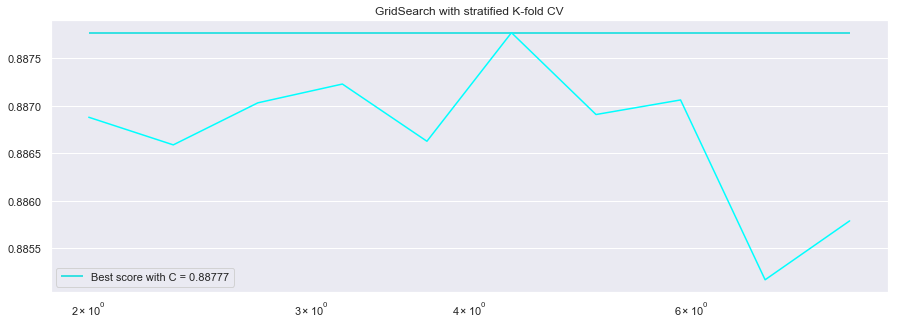

In [80]:
C_valuesS = np.logspace(1, 3, 10, base=2)

lrGSs = GridSearchCV(lrN, param_grid={'C': C_valuesS}, 
                    scoring='roc_auc', n_jobs=-1, cv=skf, verbose=1)
lrGSs.fit(X_train, y_train)
print('Best score with C = {:.5f} and stratified K-fold CV is {:.5f}'.format(
    lrGSs.best_params_['C'], lrGSs.best_score_))

plt.figure(figsize=(15,5))
plt.title('GridSearch with stratified K-fold CV')
plt.plot([lrGSs.cv_results_['params'][i]['C'] for i in range(0,10)], lrGSs.cv_results_['mean_test_score'],
         c='#00ffff')
plt.hlines(lrGSs.best_score_, C_valuesS.min(), C_valuesS.max(), color='#00dddd',
           label='Best score with C = {:.5f}'.format(lrGSs.best_score_))
plt.xscale('log')
plt.legend(loc='lower left')
plt.show()

In [81]:
predictedT = pd.Series(lrGSt.predict(X_train), name='Predicted (time)')
predictedS = pd.Series(lrGSs.predict(X_train), name='Predicted (k-fold)')

In [82]:
print('Confusion matrix by time-aware CV')
pd.crosstab(true, predictedT, rownames=['TrueT'], colnames=['PredictedT'])

Confusion matrix by time-aware CV


PredictedT,0,1
TrueT,,
0,249499,1764
1,2281,16


In [83]:
print('Confusion matrix by stratified CV')
pd.crosstab(true, predictedS, rownames=['TrueT'], colnames=['PredictedT'])

Confusion matrix by stratified CV


PredictedT,0,1
TrueT,,
0,249687,1576
1,2281,16


In [84]:
X_test = cv_full_sparse[train_idx:]
X_test = add_hours(full_df[train_idx:]['time1'], X_test)
X_test = add_cyclic(full_df[train_idx:]['time1'], X_test)
X_test = add_active_hours(full_df[train_idx:]['time1'], X_test)
X_test = add_session_length(full_df[train_idx:][times], X_test)
X_test = add_session_std(full_df[train_idx:][times], X_test)
X_test = add_active_week_day(full_df[train_idx:]['time1'], X_test)
X_test = add_week_day(full_df[train_idx:]['time1'], X_test)
X_test = add_month_dummy(full_df[train_idx:]['time1'], X_test)
X_test = add_cyclic_dayofyear(full_df[train_idx:]['time1'], X_test)

y_pred = lrGSt.predict_proba(X_test)[:,1]
write_to_submission_file(y_pred, './statics/submS.csv')

In [2]:
import dill
# dill.dump_session('./statics/notebook_env')
dill.load_session('./statics/notebook_env')

In [ ]:
del X_train, X_test, lrN, C_valuesS, C_valuesT, lrGSs, lrGSt, predictedS, predictedT, y_pred

***
### Feature selection

In [4]:
!conda list mlxtend
!conda list dill

# packages in environment at /home/biddy/anaconda2/envs/gl-env3:
#
mlxtend                   0.13.0                     py_1    conda-forge
# packages in environment at /home/biddy/anaconda2/envs/gl-env3:
#
dill                      0.2.8.2               py36_1000    conda-forge


In [73]:
tmpFull = full_df[times]
tmp = full_df['time1']

tmp1 = tmp.dt.hour*60 + tmp.dt.minute
cosH = np.cos(2*np.pi*tmp1/(16*60)).rename('cosH')
sinH = np.sin(2*np.pi*tmp1/(16*60)).rename('sinH')

tmp1 = tmp.dt.hour
activeH1 = ((tmp1>=12) & (tmp1<=13)).astype(int).rename('activeH1')
activeH2 = ((tmp1>=16) & (tmp1<=18)).astype(int).rename('activeH2')
activeH3 = (((tmp1>=7) & (tmp1<=11))|((tmp1>=14) & (tmp1<=15))).astype(int).rename('activeH3')

activeH = pd.get_dummies(tmp1, drop_first=True).T.reindex(range(1,24)).T.fillna(0).astype(int) \
        .rename(columns=dict(zip(range(1,24), ['H'+str(i) for i in range(1,24)])))
        
tmp1 = ((tmpFull.max(axis=1)-tmpFull.min(axis=1))/pd.Timedelta(minutes=1))
sesLen = pd.Series(StandardScaler().fit_transform(tmp1.values.reshape((-1,1))).flatten(), 
                   index=tmp1.index, name='sesLen')
    
tmp1 = tmpFull.applymap(lambda x: x if pd.isna(x) else x.value/1000000000).std(axis=1).fillna(0)
tmp1 = tmp1.apply(np.log1p)
sesStd = pd.Series(StandardScaler().fit_transform(tmp1.values.reshape((-1,1))).flatten(),
                   index=tmp1.index, name='sesStd')

tmp1 = tmp.dt.weekday
activeW1 = (((tmp1>=0) & (tmp1<=1))|((tmp1>=3) & (tmp1<=4))).astype(int).rename('activeW')

activeW = pd.get_dummies(tmp1, drop_first=True).T.reindex(range(1,7)).T.fillna(0).astype(int) \
        .rename(columns=dict(zip(range(1,7), ['W'+str(i) for i in range(1,7)])))

month = pd.get_dummies(tmp.dt.month, drop_first=True).T.reindex(range(2,13)).T.fillna(0).astype(int) \
        .rename(columns = dict(zip(range(2,13), ['M'+str(i) for i in range(2,13)])))

tmp1 = tmp.dt.dayofyear
sinD = np.sin(2*np.pi*tmp1/365).rename('sinD')
cosD = np.cos(2*np.pi*tmp1/365).rename('cosD')

tmpFull = pd.concat([cosH, sinH, activeH1, activeH2, activeH3, activeH, sesLen, sesStd, 
                     activeW1, activeW, month, sinD, cosD], axis=1)
X_train = tmpFull[:train_idx]
X_test = tmpFull[train_idx:]

In [6]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

sfs = SFS(lrN, k_features=20, forward=False, floating=False, cv=tsf, 
          scoring='roc_auc', n_jobs=-1, verbose=1)
sfs.fit(X_train.values, y_train, custom_feature_names=X_train.columns)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  43 out of  43 | elapsed: 13.7min finished
Features: 42/20[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 out of  42 | elapsed: 12.6min finished
Features: 41/20[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  41 out of  41 | elapsed: 12.2min finished
Features: 40/20[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 10.0min finished
Features: 39/20[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed: 10.0min finished
Features: 38/20[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 out of  38 | elapsed:  9.3min finished
Features: 37/20[Parallel(n_jobs=-1)]: Using

SequentialFeatureSelector(clone_estimator=True,
             cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=200, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False),
             floating=False, forward=False, k_features=20, n_jobs=-1,
             pre_dispatch='2*n_jobs', scoring='roc_auc', verbose=1)

In [20]:
sfs_res = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
sfs_res.sort_values(by='avg_score', ascending=False).head()

,avg_score,ci_bound,cv_scores,feature_idx,feature_names,std_dev,std_err
24,0.884976,0.0475922,"[0.8333375407173214, 0.9175285864969205, 0.876...","(0, 4, 5, 7, 8, 9, 11, 14, 15, 22, 25, 26, 27,...","(cosH, activeH3, H8, H10, H11, H12, H14, H17, ...",0.0640788,0.0213596
23,0.884927,0.0475568,"[0.8313914079996008, 0.9177061276095769, 0.873...","(0, 4, 5, 7, 8, 9, 11, 14, 15, 22, 25, 26, 27,...","(cosH, activeH3, H8, H10, H11, H12, H14, H17, ...",0.0640312,0.0213437
25,0.88487,0.0476117,"[0.8334010867237595, 0.9177444891714188, 0.876...","(0, 4, 5, 7, 8, 9, 11, 14, 15, 19, 22, 25, 26,...","(cosH, activeH3, H8, H10, H11, H12, H14, H17, ...",0.0641052,0.0213684
22,0.88482,0.0476248,"[0.8300398221640345, 0.9176966164785417, 0.874...","(0, 4, 5, 7, 8, 9, 11, 14, 15, 22, 25, 26, 27,...","(cosH, activeH3, H8, H10, H11, H12, H14, H17, ...",0.0641227,0.0213742
21,0.884716,0.0500245,"[0.8526700348951723, 0.9305792849468281, 0.872...","(0, 4, 5, 7, 8, 11, 14, 15, 22, 25, 26, 27, 28...","(cosH, activeH3, H8, H10, H11, H14, H17, H18, ...",0.0673538,0.0224513


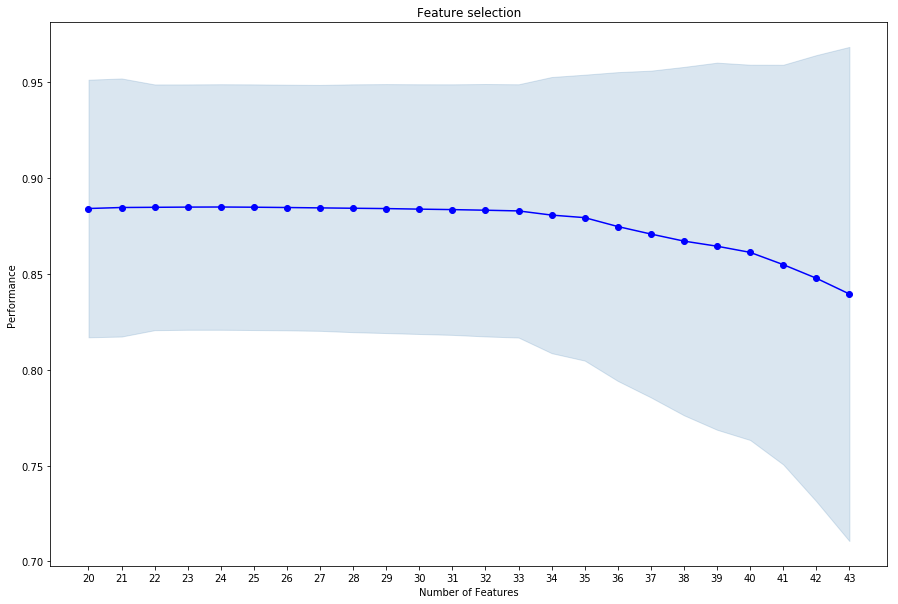

In [19]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

fig=plot_sfs(sfs.get_metric_dict(), kind='std_dev')
fig.set_size_inches(15,10)
plt.title('Feature selection')
plt.show()

In [1]:
import dill

# dill.dump_session('./statics/notebook_env2')
dill.load_session('./statics/notebook_env2')

In [2]:
best_features=list(sfs_res.sort_values('avg_score', ascending=False).iloc[1]['feature_names'])

del tmpFull, tmp, tmp1, cosH, sinH, tmp1, activeH1, activeH2, activeH3, activeH, sesLen, sesStd
del activeW1, activeW, month, sinD, cosD, X_train, X_test, sfs, sfs_res, fig, 

NameError: name 'tmp1' is not defined

### Hyperparameter tuning

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 13.2min finished


Best score with C = 3.70350 and time-aware CV is 0.93316


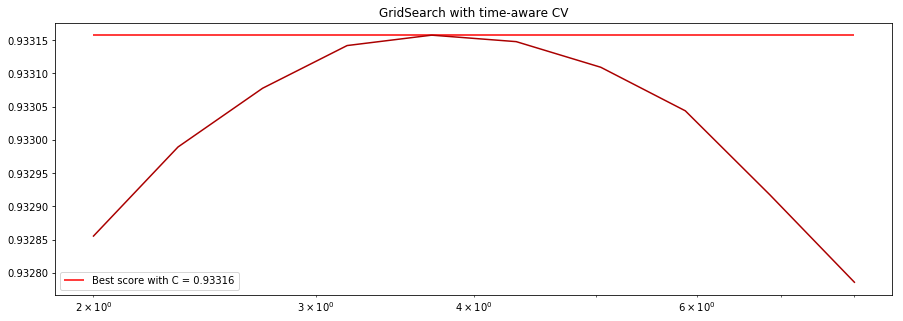

In [106]:
X_train_tfidf = hstack([X_train[best_features].values, tfidf_full_sparse[:train_idx]])
X_test_tfidf = hstack([X_test[best_features].values, tfidf_full_sparse[train_idx:]])

lrN = LogisticRegression(solver='lbfgs', max_iter=1000)
C_valuesT = np.logspace(1, 3, 10, base=2)

lrGSt = GridSearchCV(lrN, param_grid={'C': C_valuesT}, 
                    scoring='roc_auc', n_jobs=-1, cv=tsf, verbose=1)
lrGSt.fit(X_train_tfidf, y_train)
print('Best score with C = {:.5f} and time-aware CV is {:.5f}'.format(
    lrGSt.best_params_['C'], lrGSt.best_score_))

plt.figure(figsize=(15,5))
plt.title('GridSearch with time-aware CV')
plt.plot([lrGSt.cv_results_['params'][i]['C'] for i in range(0,10)], lrGSt.cv_results_['mean_test_score'],
         c='#aa0000')
plt.hlines(lrGSt.best_score_, C_valuesT.min(), C_valuesT.max(), color='#ff0000',
           label='Best score with C = {:.5f}'.format(lrGSt.best_score_))
plt.xscale('log')
plt.legend(loc='lower left')
plt.show()

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.7min finished


Best score with C = 0.23147 and time-aware CV is 0.94204


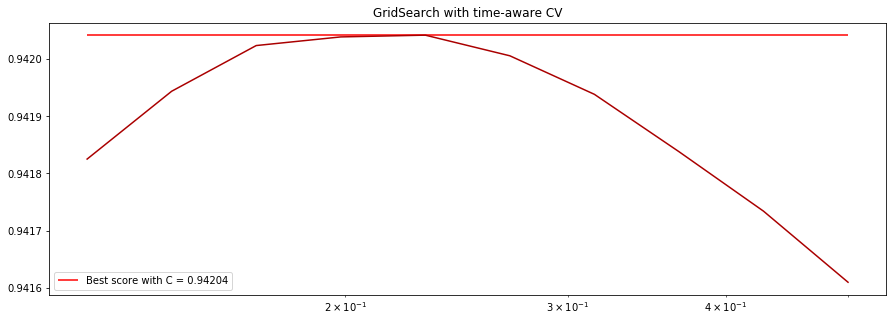

In [99]:
X_train_cv = hstack([X_train[best_features].values, cv_full_sparse[:train_idx]])
X_test_cv = hstack([X_test[best_features].values, cv_full_sparse[train_idx:]])

lrN = LogisticRegression(solver='lbfgs', max_iter=1000)
C_valuesC = np.logspace(-3, -1, 10, base=2)

lrGSc = GridSearchCV(lrN, param_grid={'C': C_valuesC}, 
                    scoring='roc_auc', n_jobs=-1, cv=tsf, verbose=1)
lrGSc.fit(X_train_cv, y_train)
print('Best score with C = {:.5f} and time-aware CV is {:.5f}'.format(
    lrGSc.best_params_['C'], lrGSc.best_score_))

plt.figure(figsize=(15,5))
plt.title('GridSearch with time-aware CV')
plt.plot([lrGSc.cv_results_['params'][i]['C'] for i in range(0,10)], lrGSc.cv_results_['mean_test_score'],
         c='#aa0000')
plt.hlines(lrGSc.best_score_, C_valuesC.min(), C_valuesC.max(), color='#ff0000',
           label='Best score with C = {:.5f}'.format(lrGSc.best_score_))
plt.xscale('log')
plt.legend(loc='lower left')
plt.show()

In [107]:
y_pred = lrGSt.predict_proba(X_test_tfidf)[:,1]
write_to_submission_file(y_pred, './statics/subm.csv')

In [ ]:
del best_features, X_train_tfidf, X_test_tfidf, X_train_cv, X_test_cv, C_valuesT, C_valuesC, lrN, lrGSt, lrGSc

***
### Polynomial features
Transform features into polynomials and test it with feature selection. Let's see what happens.

In [3]:
tmpFull = full_df[times]
tmp = full_df['time1']

tmp1 = tmp.dt.hour*60 + tmp.dt.minute
cosH = np.cos(2*np.pi*tmp1/(16*60)).rename('cosH')
sinH = np.sin(2*np.pi*tmp1/(16*60)).rename('sinH')

tmp1 = tmp.dt.hour
activeH1 = ((tmp1>=12) & (tmp1<=13)).astype(int).rename('activeH1')
activeH2 = ((tmp1>=16) & (tmp1<=18)).astype(int).rename('activeH2')
activeH3 = (((tmp1>=7) & (tmp1<=11))|((tmp1>=14) & (tmp1<=15))).astype(int).rename('activeH3')

activeH = pd.get_dummies(tmp1, drop_first=True).T.reindex(range(1,24)).T.fillna(0).astype(int) \
        .rename(columns=dict(zip(range(1,24), ['H'+str(i) for i in range(1,24)])))
        
tmp1 = ((tmpFull.max(axis=1)-tmpFull.min(axis=1))/pd.Timedelta(minutes=1))
sesLen = pd.Series(StandardScaler().fit_transform(tmp1.values.reshape((-1,1))).flatten(), 
                   index=tmp1.index, name='sesLen')
    
tmp1 = tmpFull.applymap(lambda x: x if pd.isna(x) else x.value/1000000000).std(axis=1).fillna(0)
tmp1 = tmp1.apply(np.log1p)
sesStd = pd.Series(StandardScaler().fit_transform(tmp1.values.reshape((-1,1))).flatten(),
                   index=tmp1.index, name='sesStd')

tmp1 = tmp.dt.weekday
activeW1 = (((tmp1>=0) & (tmp1<=1))|((tmp1>=3) & (tmp1<=4))).astype(int).rename('activeW')

activeW = pd.get_dummies(tmp1, drop_first=True).T.reindex(range(1,7)).T.fillna(0).astype(int) \
        .rename(columns=dict(zip(range(1,7), ['W'+str(i) for i in range(1,7)])))

month = pd.get_dummies(tmp.dt.month, drop_first=True).T.reindex(range(2,13)).T.fillna(0).astype(int) \
        .rename(columns = dict(zip(range(2,13), ['M'+str(i) for i in range(2,13)])))

tmp1 = tmp.dt.dayofyear
sinD = np.sin(2*np.pi*tmp1/365).rename('sinD')
cosD = np.cos(2*np.pi*tmp1/365).rename('cosD')

tmpFull = pd.concat([cosH, sinH, activeH1, activeH2, activeH3, activeH, sesLen, sesStd, 
                     activeW1, activeW, month, sinD, cosD], axis=1)
X_train = tmpFull[:train_idx]
X_test = tmpFull[train_idx:]

In [6]:
from sklearn.preprocessing import PolynomialFeatures

pf = PolynomialFeatures(degree=2)

tmp = pf.fit_transform(X_train.values)
cols = pf.get_feature_names(X_train.columns)

In [ ]:
X_train = tmp[:train_idx]
lr = LogisticRegression(solver='sag')
print('Score on polynomial features:', cross_val_score(lr, X_train, y_train, scoring='roc_auc', 
                                                       cv=tsf, n_jobs=-1, verbose=-1).mean())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Unfortunately Logistic Regression with Polynomial features didn't run out of memory shortage. Definitely going to need some cloud service for this computation. Let's stop here. As for 23.12.18, my current LB standing is 87th out of 2000ish.

## Conclusion
So, for this competition the data was time-series session info regarding user browser history - we have to distinct between regular user and intruder user based on sites visitied and time of visit information. EDA, data wrangling and feature engineering was performed to achieve ROC-AUC score of 0.95856. Currently implemented features:
* Dummy hour feature of session start time (from now on start time)
* Sin-cos transformation of start time
* Active start hours of intruder
* Dummy weekday feature of start time
* Active weekday of intruder feature
* Dummy month feature of start time
* Sin-cos transformation of year day feature
* Session length
* Session sites stay standard deviation

__TODO__: add features based on site:
* Number of unique sites visited feature
* Features based on most intruder visited sites
* Data wrangling on names of features (like _www.google.com_ and _google.com_ are the same)
* Somehow perform polynomial features

Let's move further now. We will revisit this notebook once I have more experience with Time-series data.